### Модель прогнозирования стоимости жилья для агентства недвижимости

Задача

Задача — разработать модель, которая позволила бы агентству
недвижимости обойти конкурентов по скорости и качеству совершения
сделок

In [1]:
# импорт необходимых библиотек

# !pip install ydata-profiling
# !pip install category-encoders
# !pip install xgboost
# !pip install catboost


import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import category_encoders as ce
import warnings
import plotly.express as px
import pickle

from datetime import datetime
from sklearn import ensemble
from ydata_profiling import ProfileReport
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import f_regression
from sklearn import feature_selection
from sklearn.ensemble import AdaBoostRegressor
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


warnings.filterwarnings("ignore")

## Знакомство с данными

In [2]:
# загрузка датафрейма
data = pd.read_csv('data/data.csv')
data

status private pool        propertyType                    street  \
0         Active          NaN  Single Family Home            240 Heather Ln   
1       for sale          NaN  single-family home         12911 E Heroy Ave   
2       for sale          NaN  single-family home         2005 Westridge Rd   
3       for sale          NaN  single-family home       4311 Livingston Ave   
4       for sale          NaN            lot/land            1524 Kiscoe St   
...          ...          ...                 ...                       ...   
377180       NaN          NaN       Single Family         20800 NE 23rd Ave   
377181  for sale          NaN               condo  3530 N Lake Shore Dr #4B   
377182  for sale          NaN  single-family home         15509 Linden Blvd   
377183       NaN          NaN                 NaN           7810 Pereida St   
377184       NaN          NaN       Single Family          5983 Midcrown Dr   

          baths                                          homeFacts  \
0           3.5  {'atAGlanceFacts': [{'factValue': '2019', 'fac...   
1       3 Baths  {'atAGlanceFacts': [{'factValue': '2019', 'fac...   
2       2 Baths  {'atAGlanceFacts': [{'factValue': '1961', 'fac...   
3       8 Baths  {'atAGlanceFacts': [{'factValue': '2006', 'fac...   
4           NaN  {'atAGlanceFacts': [{'factValue': '', 'factLab...   
...         ...                                                ...   
377180      6.0  {'atAGlanceFacts': [{'factValue': '1990', 'fac...   
377181  3 Baths  {'atAGlanceFacts': [{'factValue': '1924', 'fac...   
377182  3 Baths  {'atAGlanceFacts': [{'factValue': '1950', 'fac...   
377183      NaN  {'atAGlanceFacts': [{'factValue': None, 'factL...   
377184      2.0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...   

             fireplace            city  \
0             Gas Logs  Southern Pines   
1                  NaN  Spokane Valley   
2                  yes     Los Angeles   
3                  yes          Dallas   
4                  NaN        Palm Bay   
...                ...             ...   
377180             NaN           Miami   
377181             NaN         Chicago   
377182             NaN         Jamaica   
377183             NaN         Houston   
377184  Not Applicable     San Antonio   

                                                  schools        sqft zipcode  \
0       [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...        2900   28387   
1       [{'rating': ['4/10', 'None/10', '4/10'], 'data...  1,947 sqft   99216   
2       [{'rating': ['8/10', '4/10', '8/10'], 'data': ...  3,000 sqft   90049   
3       [{'rating': ['9/10', '9/10', '10/10', '9/10'],...  6,457 sqft   75205   
4       [{'rating': ['4/10', '5/10', '5/10'], 'data': ...         NaN   32908   
...                                                   ...         ...     ...   
377180  [{'rating': ['10/10', '5/10'], 'data': {'Dista...       4,017   33180   
377181  [{'rating': ['1/10', '5/10', '7/10'], 'data': ...  2,000 sqft   60657   
377182  [{'rating': ['5/10', '4/10'], 'data': {'Distan...  1,152 sqft   11434   
377183  [{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...         NaN   77028   
377184  [{'rating': ['5/10', '4/10', '3/10'], 'data': ...       1,462   78218   

              beds state stories mls-id PrivatePool       MlsId      target  
0                4    NC     NaN    NaN         NaN      611019    $418,000  
1           3 Beds    WA     2.0    NaN         NaN   201916904    $310,000  
2           3 Beds    CA     1.0    NaN         yes  FR19221027  $2,895,000  
3           5 Beds    TX     3.0    NaN         NaN    14191809  $2,395,000  
4              NaN    FL     NaN    NaN         NaN      861745      $5,000  
...            ...   ...     ...    ...         ...         ...         ...  
377180           5    FL     0.0    NaN         Yes   A10702700  $1,249,000  
377181      3 Beds    IL     9.0    NaN         NaN    10374233    $674,999  
377182      3 Beds    NY       2    NaN 

In [3]:
data.describe()

status private pool        propertyType                 street  \
count     337267         4181              342452                 377183   
unique       159            1                1280                 337076   
top     for sale          Yes  single-family home  Address Not Disclosed   
freq      156104         4181               92206                    672   

          baths                                          homeFacts fireplace  \
count    270847                                             377185    103114   
unique      229                                             321009      1652   
top     2 Baths  {'atAGlanceFacts': [{'factValue': '', 'factLab...       yes   
freq      52466                                               7174     50356   

           city                                            schools    sqft  \
count    377151                                             377185  336608   
unique     2026                                             297365   25405   
top     Houston  [{'rating': [], 'data': {'Distance': [], 'Grad...       0   
freq      24442                                               4204   11854   

       zipcode    beds   state stories   mls-id PrivatePool   MlsId    target  
count   377185  285903  377185  226469    24942       40311  310305    374704  
unique    4549    1184      39     347    24907           2  232944     43939  
top      32137  3 Beds      FL     1.0  No MLS#         yes  NO MLS  $225,000  
freq      2141   53459  115449   67454        3       28793      24      1462

In [4]:
# посмотрим на картину с признаками
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Видно, что все объекты представлены типом object и во всех признаках имеются пропуски. Также у нас есть два столбца 'private pool' и 'msl-id'

In [5]:
# выводим столбцы, где доля пропусков больше нуля
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

private pool    98.891525
mls-id          93.387330
PrivatePool     89.312672
fireplace       72.662221
stories         39.958111
baths           28.192532
beds            24.200856
MlsId           17.731352
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
dtype: float64

<Axes: >

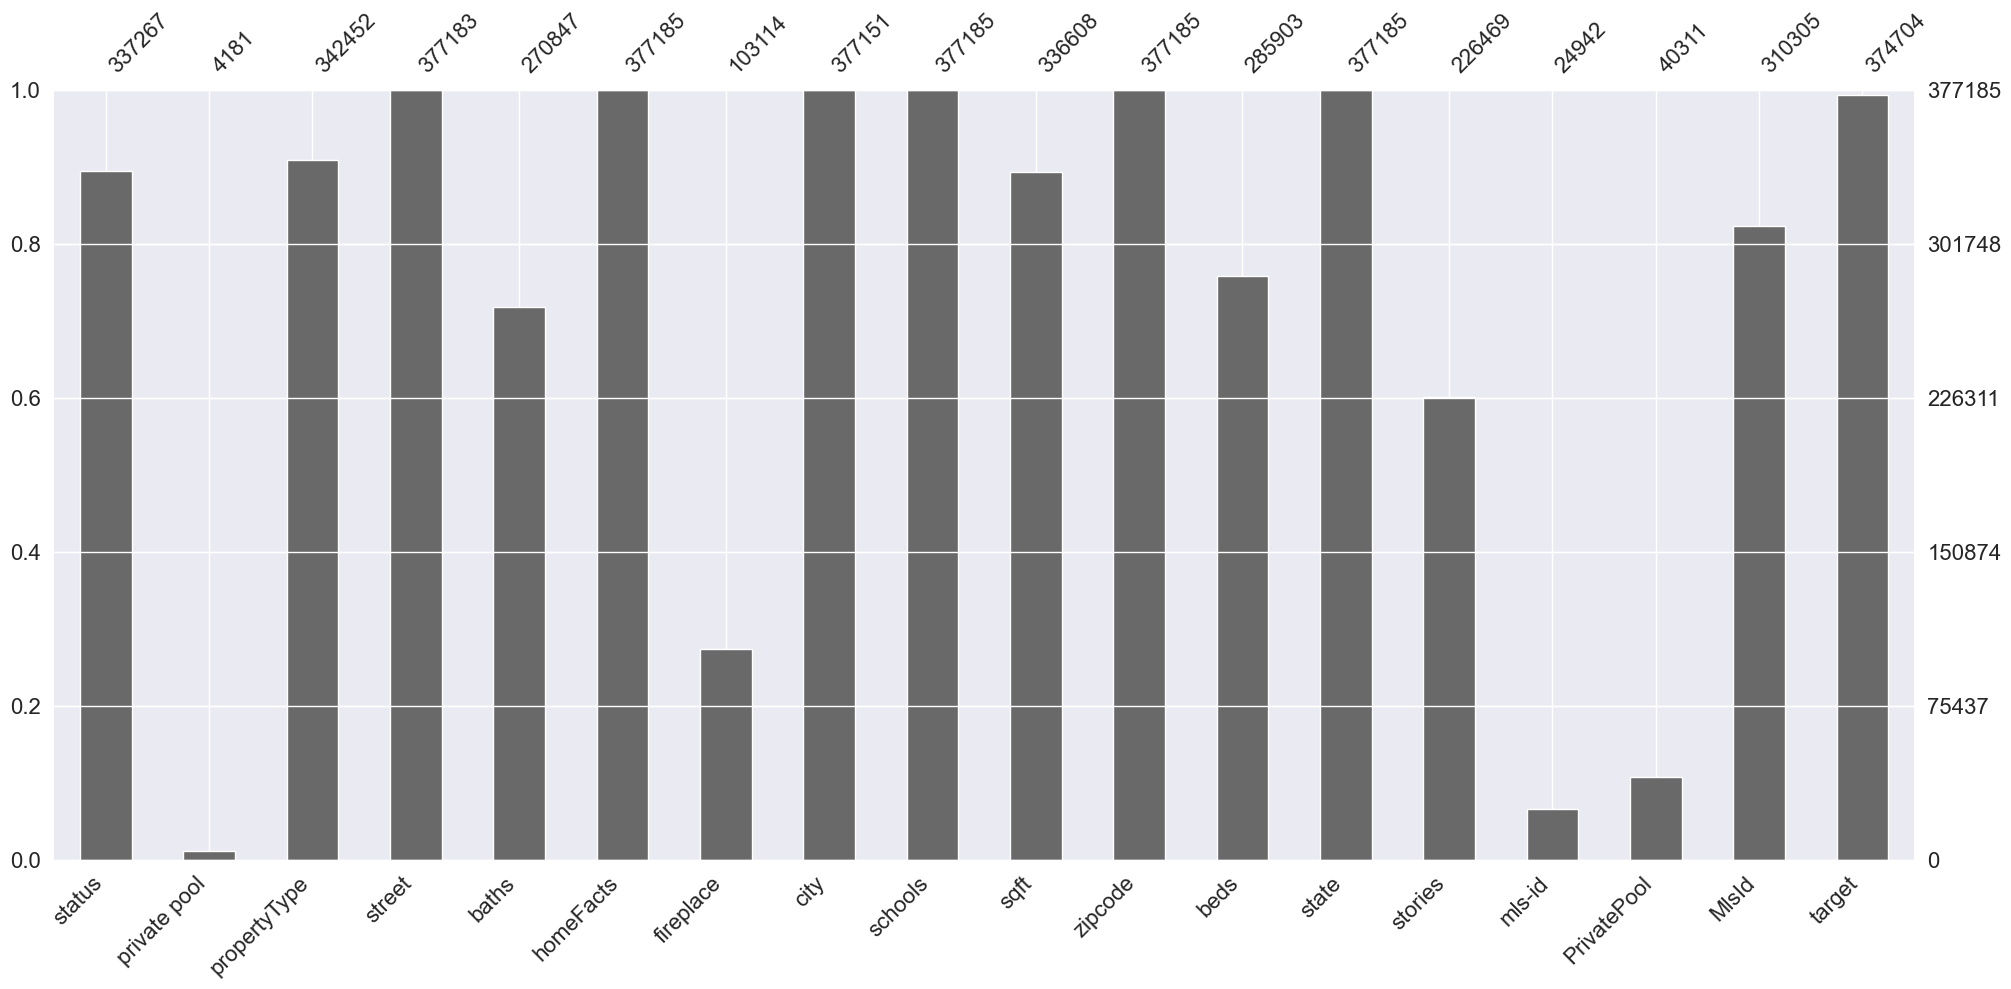

In [6]:
# Визуализируем таблицы с пропусками
sns.set()
msno.bar(data)

Описание данных:

- 'status' — статус продажи;
- 'private pool' и 'PrivatePool' — наличие собственного бассейна;
- 'propertyType' — тип объекта недвижимости;
- 'street' — адрес объекта;
- 'baths' — количество ванных комнат;
- 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
- 'fireplace' — наличие камина;
- 'city' — город;
- 'schools' — сведения о школах в районе;
- 'sqft' — площадь в футах;
- 'zipcode' — почтовый индекс;
- 'beds' — количество спален;
- 'state' — штат;
- 'stories' — количество этажей;
- 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);
- 'target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

## Обработка и очистка данных

In [7]:
# удалим дубликаты
data_drop = data.drop_duplicates()
print('Удалённых значений : ', round(100 - data_drop.shape[0]/data.shape[0]*100, 2), "%")

Удалённых значений :  0.01 %


Удалим столбцы в которых больше 40% пропусков. В том числе и private pool и PrivatePool. MlsId и mls-id являются уникальными значениями, поэтому тоже подлежат удалению.

In [8]:
# удлим неинформативные столбцы
thresh = data_drop.shape[0]*0.6
df_thresh = data_drop.dropna(thresh=thresh, axis=1)
df = df_thresh.drop(columns=['MlsId'])
print("Осталось", df_thresh.shape[1], "столбцов из 18")

Осталось 14 столбцов из 18


### Статус продажи (status)

In [9]:
# посмотрим количество уникальных значений
df["status"] = df["status"].str.lower()
df["status"].value_counts(dropna=False, normalize=True) * 100

status
for sale                52.905193
active                  27.896377
NaN                     10.584274
foreclosure              1.794583
new construction         1.451470
                          ...    
coming soon: dec 25.     0.000265
coming soon: oct 24.     0.000265
pending take backups     0.000265
contract                 0.000265
coming soon: dec 23.     0.000265
Name: proportion, Length: 153, dtype: float64

153 уникальных значения, причём 10% пропущенных значений

In [10]:
# посмотрим список уникальных значений
df["status"].unique()

array(['active', 'for sale', nan, 'new construction', 'new', 'pending',
       'p', 'active/contingent', 'pre-foreclosure / auction',
       ' / auction', 'under contract', 'under contract   showing',
       'pre-foreclosure', 'under contract backups', 'foreclosure',
       'active under contract', 'foreclosed', 'option pending',
       'under contract show', 'for rent', 'auction', 'a active',
       'contingent', 'pending   continue to show', 'price change',
       'back on market', 'active option', 'recently sold',
       'coming soon: nov 21.', 'contingent finance and inspection',
       'coming soon: dec 4.', 'p pending sale', 'coming soon: nov 23.',
       'active with contingencies', 'pending ab', 'pf', 'contingent show',
       'contract p', 'contingent take backup', 'apartment for rent',
       'backup contract', 'option contract', 'pending continue to show',
       'pending inspection', 'active option contract', 'c',
       'auction - active', 'contingent   show', 'pi',
      

Варианты статуса
1.  status — статус, состояние.
2. estate — объект недвижимости.
3. 'foreclosed' ('foreclosure') — «лишён права выкупа». Это процесс,
когда недвижимость переходит к кредитору из-за неуплаты
ипотеки заёмщиком. Продажа foreclosure-недвижимости
отличается от традиционных продаж.
4. 'pre foreclosure' ('pre foreclosure auction') — «до выкупа», «аукцион до
выкупа».
5. 'under contract showing' ('under contract show', 'under contract', 'active
under contract') — предложение о покупке уже сделано, но не
принято продавцом окончательно, и недвижимость продолжают
показывать другим потенциальным покупателям.
6. 'under contract backups', 'active backup', 'backup contract' —
предложение о покупке уже сделано и принято продавцом, однако
он открыт для резервных предложений.
7. 'contingency' — дополнительные обстоятельства (критерии,
которым должен соответствовать продавец/покупатель до
завершения сделки).
8. 'contingency contract' — контракт на случай возникновения
дополнительных обстоятельств.
9. 'active contingency' — сделка уже практически состоялась, однако
продавцу/покупателю для её завершения необходимо выполнить
какие-то условия.
10. 'insp inspection contingency' — ситуация, когда покупатель может
официально проинспектировать объект недвижимости в
определённый период времени.
11. 'pending escape clause' — договор, предполагающий свободный
выход сторон из него.
12. 'pending backup wanted' — договор уже заключен, однако продавец
хочет продолжать показывать недвижимость другим
потенциальным покупателям и принимать резервные
предложения.
13. 'pending take backups' — условие, предполагающее, что продавец
может принимать резерные предложения, если сделка с текущим
покупателем не состоится.
14. 'pending continue show' — договор уже заключен, однако продавец
хочет продолжать показывать недвижимость другим
потенциальным покупателям на случай, если текущая сделка не
состоится.
15. 'pending inspection' — «в ожидании инспекции».
16. 'due diligence period' — период, в течение которого покупатель
имеет право проинспектировать недвижимость и изучить всю
важную для заключения сделки информацию.
17. 'activated' — «активен», открыт для покупки.
18. 'active with contract' — продавец уже принял предложение о
покупке, однако сделка ещё не закрыта.
19. 'active with offer' — продавец принял предложение о покупке,
однако ищет резервные предложения на случай, если сделка с
текущим покупателем не состоится.
Дипломный проект. Бриф учебного кейса «Модель
прогнозирования стоимости жилья для агентства недвижимости»
20. 'active auction', 'auction active', 'auction' — продажа недвижимости с
помощью аукциона.
21.  cooling-off period — период, в течение которого покупатель может
расторгнуть договор после завершения сделки.

In [11]:
# сделаем замены
df['status'] = df['status'].replace('foreclosure', 'foreclosed')
df['status'] = df['status'].replace('pre foreclosure auction', 'pre foreclosure')
df['status'] = df['status'].replace('under contract show', 'under contract showing').replace('under contract', 'under contract showing').replace('active under contract', 'under contract showing')
df['status'] = df['status'].replace('active backup', 'under contract backups').replace('backup contract', 'under contract backups')

In [12]:
# заполним пропуски самым распространённым значением
df['status'] = df['status'].fillna(df['status'].describe().top)

Поскольку основная часть покрывается пятью вариантами, остальное отправим в категорию other

In [13]:
status_list = list(df['status'].value_counts()[:6].index)
df['status'] = df['status'].apply(lambda x: x if x in status_list else 'other')

In [14]:
df["status"].value_counts(normalize=True) * 100

status
for sale                  63.489467
active                    27.896377
other                      3.284235
foreclosed                 1.916290
new construction           1.451470
pending                    1.274610
under contract showing     0.687552
Name: proportion, dtype: float64

### Тип объекта недвижимости (propertyType)

In [15]:
# посмотрим количество уникальных значений
# приведём столбец к нижнему регистру
df["propertyType"] = df["propertyType"].str.lower()
df["propertyType"].value_counts(dropna=False, normalize=True)

propertyType
single-family home                                             0.244472
single family                                                  0.166696
condo                                                          0.112758
NaN                                                            0.092097
single family home                                             0.084129
                                                                 ...   
custom, elevated, other                                        0.000003
contemporary, farmhouse                                        0.000003
2 stories, traditional, mediterranean, texas hill country      0.000003
1 story, contemporary, traditional, mediterranean              0.000003
bilevel, converted dwelling, loft with bedrooms, condo/unit    0.000003
Name: proportion, Length: 1273, dtype: float64

Видно, что уникальных значений 1 273 и 9% пропущенных значений

In [16]:
# заполним пропуски самым распространённым значением
df['propertyType'] = df['propertyType'].fillna(df['propertyType'].describe().top)

 Типы жилья:
1. apartment — съёмная квартира (нельзя купить);
2. condo — кондоминиум (можно купить);
3. co-op — квартира в жилищном кооперативе;
4. single-family (detached, tiny home) — односемейный (отдельный,
маленький) дом;
5. townhome, townhouse — таунхаус;
6. cape cod — черепичная крыша, облицовка деревянным сайдингом,
дверь в центре здания, окна по бокам, один-два этажа;
7. colonial home — минимум два этажа, симметрия, лестница в центре
здания, строгий внешний вид;
8. contemporary — чистые, простые линии, нейтральные цвета,
натуральные текстуры;
9. cottage — небольшая уютная веранда, небольшие жилые
помещения;
10. craftsman — деревянные элементы ручной работы, выступающие
балки, большие колонны;
11. Greek revival — большие белые колонны, украшения в греческом
стиле, нарядный вход;
12. farmhouse — прямоугольная планировка, большое крыльцо,
амбарная крыша;
Дипломный проект. Бриф учебного кейса «Модель
прогнозирования стоимости жилья для агентства недвижимости»
13. French country — влияние прованса, облицовка камнем,
состаренный вид;
14. Mediterranean — белая штукатурка, дерево и камень в тёплых тонах,
черепичные крыши, элементы испанских и итальянских вилл;
15. midcentury modern — сочетание плавных природных и строгих
геометрических линий, гладкость, лаконичность, большие окна;
16. ranch — один этаж, низкая крыша, открытые жилые помещения,
задний двор;
17. split-level — жилые помещения разделены короткими лестничными
пролётами;
18. Tudor — деревянные балки, каменная кладка, асимметричная
крутая двускатная крыша;
19. Victorian (Queen Anne Houses) — два-три и более этажей, богатый
декор, крутая двускатная крыша, небольшие башенки, яркий фасад;
20. European Houses style — кирпич или камень, высокая крутая крыша,
высокие окна, часто со ставнями, традиционные декоративные
детали (фронтоны, замковые камни);
21. log home — деревянный дом.


In [17]:
# проводим удаление(замену) ненужных символов
df['propertyType'] = df['propertyType'].apply(lambda x: ' '.join(x.replace('-', ' ').replace(',', ' ').replace('/', ' ').split(' ')[0:2]))
df['propertyType'] = df['propertyType'].replace('condo townhome', 'condo').replace('lot land', 'land').replace('detached ', 'single detached')
df['propertyType'] = df['propertyType'].replace('manufactured home', 'manufactured house').replace('mobile', 'manufactured house').replace('prefab', 'manufactured house').replace('modular', 'manufactured house')
df['propertyType'] = df['propertyType'].replace('mo2 le', 'mobile').replace('mo2le', 'mobile')
df['propertyType'] = df['propertyType'].replace('mid century', 'midcentury').replace('mid-century', 'midcentury')
df['propertyType'] = df['propertyType'].replace('ca2 n', 'cabin').replace('ca2n', 'cabin')
df['propertyType'] = df['propertyType'].replace('single-family home', 'single family')
df['propertyType'] = df['propertyType'].replace('detached', 'single family').replace('tiny home', 'single family')
df['propertyType'] = df['propertyType'].replace('townhome', 'townhouse')
df['propertyType'] = df['propertyType'].replace('Victorian', 'Queen Anne Houses')
df['propertyType'] = df['propertyType'].replace('1 story', 'one story')
df['propertyType'] = df['propertyType'].replace('ranch', 'farms ranches')
df['propertyType'] = df['propertyType'].replace('mfd mobile', 'mobile').replace('mobile manufactured ', 'mobile')

In [18]:
# посмотрим количество уникальных значений
df["propertyType"].value_counts(normalize=True)[:25] * 100

propertyType
single family          58.760921
condo                  13.532024
land                    8.341840
townhouse               4.876768
multi family            3.238893
traditional             1.567874
single detached         1.499198
coop                    0.865738
one story               0.673499
farms ranches           0.570618
high rise               0.530844
mobile manufactured     0.429024
contemporary            0.412850
2 stories               0.412850
contemporary modern     0.352129
colonial                0.319514
mobile                  0.282657
apartment               0.244210
mobile                  0.210004
transitional            0.148488
cooperative             0.141859
florida                 0.140533
bungalow                0.117199
two story               0.092009
garden home             0.089888
Name: proportion, dtype: float64

In [19]:
# оставим 15 категорий, остальное отправим в категорию 'other'
propertyType_list = list(df['propertyType'].value_counts()[:10].index)
df['propertyType'] = df['propertyType'].apply(lambda x: x if x in propertyType_list else 'other')

In [20]:
df["propertyType"].value_counts(normalize=True)[:25] * 100

propertyType
single family      58.760921
condo              13.532024
land                8.341840
other               6.072627
townhouse           4.876768
multi family        3.238893
traditional         1.567874
single detached     1.499198
coop                0.865738
one story           0.673499
farms ranches       0.570618
Name: proportion, dtype: float64

### Улица (street)

In [21]:
df["street"] = df["street"].str.lower()
df["street"].value_counts(dropna=False)

street
address not disclosed    672
undisclosed address      517
(undisclosed address)    391
address not available    175
unknown address           72
                        ... 
2654 169th st              1
1003 w oxford st           1
6 loney cir                1
4040 nw 19th st #101       1
5983 midcrown dr           1
Name: count, Length: 336267, dtype: int64

In [22]:
# заполним пропуски самым распространённым значением
df['street'] = df['street'].fillna(df['street'].describe().top)

In [23]:
#  создадим новый столбец без числа до и после названия улицы и сделаем в нём замены
df['street_new'] = df['street'].apply(lambda x: ' '.join(x.split(' ')[1:4])).replace('', 'address not disclosed').replace('address not disclosed', 'not disclosed')\
    .replace('undisclosed address', 'address not disclosed').replace('(undisclosed address)', 'address not disclosed')\
    .replace('address not available', 'address not disclosed').replace('unknown address', 'address not disclosed')\
    .replace('#', '').replace('0', '').replace('1', '').replace('2', '').replace('3', '').replace('4', '').replace('5', '').replace('6', '')\
    .replace('7', '').replace('8', '').replace('9', '').replace('address', 'address not disclosed')
df = df.drop(['street'], axis=1)
df['street']  = df['street_new']
df = df.drop(['street_new'], axis=1)
df.head(5)

status   propertyType    baths  \
0    active  single family      3.5   
1  for sale  single family  3 Baths   
2  for sale  single family  2 Baths   
3  for sale  single family  8 Baths   
4  for sale           land      NaN   

                                           homeFacts            city  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Southern Pines   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Spokane Valley   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...     Los Angeles   
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...          Dallas   
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...        Palm Bay   

                                             schools        sqft zipcode  \
0  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...        2900   28387   
1  [{'rating': ['4/10', 'None/10', '4/10'], 'data...  1,947 sqft   99216   
2  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...  3,000 sqft   90049   
3  [{'rating': ['9/10', '9/10', '10/10', '9/10'],...  6,457 sqft   75205   
4  [{'rating': ['4/10', '5/10', '5/10'], 'data': ...         NaN   32908   

     beds state stories      target          street  
0       4    NC     NaN    $418,000      heather ln  
1  3 Beds    WA     2.0    $310,000     e heroy ave  
2  3 Beds    CA     1.0  $2,895,000    westridge rd  
3  5 Beds    TX     3.0  $2,395,000  livingston ave  
4     NaN    FL     NaN      $5,000       kiscoe st

In [24]:
df["street"].value_counts(dropna=False)

street
not disclosed            870
rd                       643
address not disclosed    589
collins ave apt          570
s miami ave              442
                        ... 
steeplechase cir           1
otterwood ct               1
misty garden cir           1
w chama rd                 1
pereida st                 1
Name: count, Length: 151897, dtype: int64

In [25]:
# напишем функцию для выделения подтипа улиц

# На вход данной функции поступает строка с адресом.
def get_street_type(address):
# Создаём список географических пометок exclude_list.
    exclude_list = ['N', 'S', 'W', 'E']
# Метод split() разбивает строку на слова по пробелу.
# В результате получаем список слов в строке и заносим его в переменную address_list.
    address_list = address.split(' ')
# Обрезаем список, оставляя в нём только последний элемент,
# потенциальный подтип улицы, и заносим в переменную street_type.
    street_type = address_list[-1]
# Делаем проверку на то, что полученный подтип является географической пометкой.
# Для этого проверяем его на наличие в списке exclude_list.
    if street_type in exclude_list:
# Если переменная street_type является географической пометкой,
# переопределяем её на второй элемент с конца списка address_list.
        street_type = address_list[-2]
# Возвращаем переменную street_type, в которой хранится подтип улицы.
    return street_type

У нас имеется слишком много уникальных значений, можно попробовать извлечь их признака характеристику подтипа

In [26]:
# Применим эту функцию и заменим пустые значения
df['street_types'] = df['street'].apply(get_street_type)
df['street_types'] = df['street_types'].replace('', 'st')
df["street_types"].value_counts(dropna=False, normalize=True)[:20] *100

street_types
st      23.331963
dr      13.276148
ave     11.197051
rd       6.124332
ln       4.923171
ct       3.991939
blvd     2.127355
way      1.926631
pl       1.925570
cir      1.659618
apt      1.422302
ter      1.214154
unit     1.124001
ne       1.056651
nw       1.015551
s        0.947141
n        0.856192
trl      0.726530
se       0.680923
#        0.627362
Name: proportion, dtype: float64

In [27]:
# Удалим приизнак улицы как неинформативный и оставить 10 самых популярных типов улиц, остальнон в отдельную категорию
df = df.drop(['street'], axis=1)
street_types_list = list(df['street_types'].value_counts()[:10].index)
df['street_types'] = df['street_types'].apply(lambda x: x if x in street_types_list else 'other')

### Количество ванных комнат (baths)

In [28]:
df["baths"].value_counts(dropna=False, normalize=True) *100

baths
NaN           28.188315
2 Baths       13.909608
3 Baths        9.413870
2              5.422992
2.0            4.394978
                ...    
4.75 Baths     0.000265
5.25 Baths     0.000265
41.0           0.000265
1.8 Baths      0.000265
44.0           0.000265
Name: proportion, Length: 230, dtype: float64

In [29]:
# выполним необходимые замены
df["baths"] = df["baths"].str.lower().str.replace('baths', '').str.replace('bathrooms:', '').str.replace('.0', '')\
    .str.replace('one', '1').str.replace('two', '2').str.replace('+', '')\
    .str.replace('ba', '').str.replace('-', '').str.replace(',', '.').str.replace('semimod', '').str.replace('/', '')\
    .str.replace('sq. ft', '').str.replace('—', '').str.replace(' ', '').str.replace('~', '')

In [30]:
df["baths"].value_counts(dropna=False, normalize=True)[:10] *100

baths
NaN    28.188315
2      26.970183
3      17.233086
4       6.905220
1       4.375887
2.5     3.418405
5       2.445543
3.5     1.457833
6       1.140706
0       1.015286
Name: proportion, dtype: float64

In [31]:
# оставим 10 самых популярных вариантов количества ванных комнат, остальнон в отдельную категорию. У нас есть тип недвижимости земля, так что нулевое значение не является выбросом
df['baths'] = df['baths'].str.replace('Nan', 'другое')
baths_list = list(df['baths'].value_counts()[:10].index)
df['baths'] = df['baths'].apply(lambda x: x if x in baths_list else 'other')
df["baths"].value_counts(dropna=False, normalize=True) *100

baths
other    34.452119
2        26.970183
3        17.233086
4         6.905220
1         4.375887
2.5       3.418405
5         2.445543
3.5       1.457833
6         1.140706
0         1.015286
1.500     0.585732
Name: proportion, dtype: float64

### Сведения о строительстве объекта (homeFacts)

Признак'homeFacts' представляет собой словарь, и
содержит несколько типов сведений. Необходимо десериализовать
содержимое этих признаков

In [32]:
# посмотрим из чего состоит признак homeFacts
str_homeFacts = df['homeFacts'].iloc[2]
str_homeFacts

"{'atAGlanceFacts': [{'factValue': '1961', 'factLabel': 'Year built'}, {'factValue': '1967', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced Air', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': 'Attached Garage', 'factLabel': 'Parking'}, {'factValue': '8,626 sqft', 'factLabel': 'lotsize'}, {'factValue': '$965/sqft', 'factLabel': 'Price/sqft'}]}"

In [33]:
# преобразование строки в словарь
df['homeFacts_new'] = df['homeFacts'].apply(lambda x: ast.literal_eval(x))

In [34]:
# создание новых признаков
df['year_built'] = df['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])
df['remodeled_year'] = df['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])
df['heating'] = df['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])
df['cooling'] = df['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])
df['parking'] = df['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])
df['lotsize'] = df['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])
df['price_sqft'] = df['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])

# удаление первначального признака
df = df.drop(['homeFacts'], axis=1)
df = df.drop(['homeFacts_new'], axis=1)

df.head(5)

status   propertyType  baths            city  \
0    active  single family    3.5  Southern Pines   
1  for sale  single family      3  Spokane Valley   
2  for sale  single family      2     Los Angeles   
3  for sale  single family  other          Dallas   
4  for sale           land  other        Palm Bay   

                                             schools        sqft zipcode  \
0  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...        2900   28387   
1  [{'rating': ['4/10', 'None/10', '4/10'], 'data...  1,947 sqft   99216   
2  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...  3,000 sqft   90049   
3  [{'rating': ['9/10', '9/10', '10/10', '9/10'],...  6,457 sqft   75205   
4  [{'rating': ['4/10', '5/10', '5/10'], 'data': ...         NaN   32908   

     beds state stories      target street_types year_built remodeled_year  \
0       4    NC     NaN    $418,000           ln       2019                  
1  3 Beds    WA     2.0    $310,000          ave       2019                  
2  3 Beds    CA     1.0  $2,895,000           rd       1961           1967   
3  5 Beds    TX     3.0  $2,395,000          ave       2006           2006   
4     NaN    FL     NaN      $5,000           st                             

                  heating  cooling          parking      lotsize price_sqft  
0  Central A/C, Heat Pump                                   None       $144  
1                                                      5828 sqft  $159/sqft  
2              Forced Air  Central  Attached Garage   8,626 sqft  $965/sqft  
3              Forced Air  Central  Detached Garage   8,220 sqft  $371/sqft  
4                                                    10,019 sqft       None

#### Год постройки (year_built)

In [35]:
df['year_built'].value_counts(dropna=False, normalize=True) * 100

year_built
        15.572408
2019     8.529572
2006     2.123378
2005     1.989473
2007     1.896138
          ...    
1823     0.000265
1740     0.000265
1700     0.000265
1807     0.000265
1804     0.000265
Name: proportion, Length: 231, dtype: float64

In [36]:
df['year_built'].unique()

array(['2019', '1961', '2006', '', '1920', '1976', '1970', '1965', '2015',
       '1996', '1982', '1905', '2008', '1899', '2016', '1954', '1989',
       '2014', '1915', '1994', '1910', '1923', '1960', '1977', '1972',
       '1963', '1981', '1949', '1930', '1991', '1958', '2005', '2017',
       '2018', '1983', '1928', '1998', '1997', '1964', '1974', '1940',
       '1973', '1968', '1999', '1918', '2007', '1984', '1946', '2003',
       '2000', '2004', '1969', '2002', '1952', '1947', '1957', '1978',
       '1956', '1967', '1975', '1988', '1955', '1950', '1959', '2012',
       '1924', '1966', '1992', '2001', '1995', '1985', '2010', '1971',
       '1909', '1953', '1993', '1990', '1980', '1951', '1907', '1885',
       '1941', '1927', '1929', '1901', None, '1922', '1906', '1945',
       '1979', '2009', '1962', '1913', '2011', '1897', '1987', '2020',
       '1926', '1939', '1925', '2013', '1986', 'No Data', '1943', '1935',
       '1890', '1900', '1895', '1911', '1948', '1942', '1916', '1931',
 

In [37]:
# заменим пропуски и выбросы на nan

# узнаем текущий год
current_year = datetime.now().year

df['year_built'] = df['year_built'].apply(lambda x: np.nan if x == '' else np.nan if x == 'No Data' else np.nan if x is None else x)
df['year_built'] = df['year_built'].apply(lambda x: int(x) if x is not np.nan else x)


def year_built(year, current_year):
    """функция для замены выбросов

    Args:
        year (Series): столбец из датасета

    Returns:
        year (Series): столбец из датасета без выбросов
    """

    if year is np.nan:
        return year
    elif year > current_year or year < 1800:
            return np.nan
    else:
        return year

# применим функцию
df['year_built'] = df['year_built'].apply(year_built, current_year = current_year)
# посмотрим на распределение значений
df['year_built'].value_counts(dropna=False, normalize=True) * 100


year_built
NaN       16.862662
2019.0     8.529572
2006.0     2.123378
2005.0     1.989473
2007.0     1.896138
            ...    
1802.0     0.000265
1811.0     0.000265
1807.0     0.000265
1809.0     0.000265
1804.0     0.000265
Name: proportion, Length: 210, dtype: float64

In [38]:
df['year_built'] = df['year_built'].fillna(df['year_built'].median())

#### Год реконструкции (remodeled_year)

In [41]:
df['remodeled_year'].value_counts(dropna=False, normalize=True) * 100

remodeled_year
        52.897504
None     7.044427
2006     1.468440
2005     1.277261
2007     1.163244
          ...    
1870     0.000265
1845     0.000265
1846     0.000265
1869     0.000265
1862     0.000265
Name: proportion, Length: 155, dtype: float64

In [42]:
df['remodeled_year'].unique()

array(['', '1967', '2006', None, '2015', '1997', '2019', '1982', '1905',
       '2009', '2007', '1996', '1995', '1988', '1972', '1949', '1954',
       '1930', '2003', '2000', '1994', '2005', '1983', '1965', '1968',
       '1993', '1999', '2014', '2008', '2010', '2004', '2002', '1984',
       '1952', '1978', '1975', '1971', '1947', '1957', '1950', '2012',
       '1973', '1970', '2016', '1989', '1998', '1980', '1986', '1955',
       '1991', '2011', '2017', '1941', '2001', '1990', '1979', '1901',
       '1918', '1977', '1962', '1956', '2013', '1960', '1981', '1969',
       '1987', '1958', '1910', '1925', '1964', '1966', '1992', '1943',
       '1961', '1948', '1931', '1976', '1974', '1935', '1940', '2018',
       '1916', '1914', '1963', '1985', '1951', '1944', '1942', '1959',
       '1927', '1946', '1945', '1920', '1938', '1936', '0', '1939',
       '1915', '1928', '1923', '1929', '1898', '1899', '1934', '1953',
       '1926', '1937', '1912', '1917', '1906', '1932', '1919', '1921',
       

In [43]:
# сделаем необходимы замены и приведём к числовому формату
df['remodeled_year'] = df['remodeled_year'].replace('', np.nan)
df['remodeled_year'] = df['remodeled_year'].apply(lambda x: np.nan if x is None else x)
df['remodeled_year'] = df['remodeled_year'].apply(lambda x: x if x is np.nan else int(x))

In [44]:
df['remodeled_year'].unique()

array([  nan, 1967., 2006., 2015., 1997., 2019., 1982., 1905., 2009.,
       2007., 1996., 1995., 1988., 1972., 1949., 1954., 1930., 2003.,
       2000., 1994., 2005., 1983., 1965., 1968., 1993., 1999., 2014.,
       2008., 2010., 2004., 2002., 1984., 1952., 1978., 1975., 1971.,
       1947., 1957., 1950., 2012., 1973., 1970., 2016., 1989., 1998.,
       1980., 1986., 1955., 1991., 2011., 2017., 1941., 2001., 1990.,
       1979., 1901., 1918., 1977., 1962., 1956., 2013., 1960., 1981.,
       1969., 1987., 1958., 1910., 1925., 1964., 1966., 1992., 1943.,
       1961., 1948., 1931., 1976., 1974., 1935., 1940., 2018., 1916.,
       1914., 1963., 1985., 1951., 1944., 1942., 1959., 1927., 1946.,
       1945., 1920., 1938., 1936.,    0., 1939., 1915., 1928., 1923.,
       1929., 1898., 1899., 1934., 1953., 1926., 1937., 1912., 1917.,
       1906., 1932., 1919., 1921., 1924., 1907., 1911., 1900., 1889.,
       1913., 1895., 1908., 1903., 1904., 1933., 1894., 1892., 1922.,
       1909., 1880.,

Дата реконструкции может быть только после даты постройки

In [45]:
df['remodeled_year'] = df.apply(lambda x: np.nan if x.remodeled_year <= x.year_built else x.remodeled_year, axis=1)

In [46]:
df['remodeled_year'].value_counts(dropna=False, normalize=True) * 100

remodeled_year
NaN       84.152624
1980.0     0.542246
1970.0     0.531375
2006.0     0.488154
1975.0     0.479669
            ...    
1899.0     0.000265
1894.0     0.000265
1880.0     0.000265
1908.0     0.000265
1892.0     0.000265
Name: proportion, Length: 131, dtype: float64

поскольку мы имеем 83% пропусков и ошибочных данных, лучше будет удалить этот столбец

In [47]:
df = df.drop(['remodeled_year'], axis=1)
df = df.drop(['year_built'], axis=1)

####  Отопление (heating)

In [48]:
df['heating'].value_counts(dropna=False, normalize=True)[:20] * 100

heating
                         28.043008
Forced Air               21.956063
Forced air               13.656648
Other                     7.854482
Electric                  2.707253
Gas                       2.464104
No Data                   2.283002
Central Air               2.071937
Central Electric          1.885797
Central                   1.656436
Heat Pump                 1.618519
Central, Electric         1.127713
Baseboard                 1.011574
None                      0.936800
Wall                      0.875283
Electric Heat             0.812441
Heat pump                 0.728386
Heating System            0.718310
Forced air, Heat pump     0.457926
Radiant                   0.393758
Name: proportion, dtype: float64

In [49]:
# Сделаем нужные преобразования и замены

# приведём столбец к нижнему регистру
df['heating'] = df['heating'].str.lower()

df['heating'] = df['heating'].replace('', 'no data').replace('none', 'no data')
df['heating'] = df['heating'].str.replace(',', '')
df['heating'] = df['heating'].str.replace('central heating', 'central')

In [50]:
df['heating'].value_counts(dropna=False, normalize=True)[:20] * 100

heating
forced air                    35.612712
no data                       30.345102
other                          7.854482
central electric               3.013510
electric                       2.708844
gas                            2.464900
heat pump                      2.346905
central air                    2.071937
central                        1.827727
baseboard                      1.011574
None                           0.936800
wall                           0.875283
electric heat                  0.812441
heating system                 0.718310
forced air heat pump           0.468532
radiant                        0.393758
central air ceiling fan(s)     0.379705
natural gas heat               0.366712
central furnace                0.274703
central electric zoned         0.264362
Name: proportion, dtype: float64

In [51]:
# оставим 10 самых популярных котегорий, остальное отправим в other
heating_list = list(df['heating'].value_counts()[:10].index)

df['heating'] = df['heating'].apply(lambda x: x if x in heating_list else 'other')

#### Охлаждение (cooling)

In [52]:
df['cooling'].value_counts(dropna=False, normalize=True)[:20] * 100

cooling
Central                                            42.092089
                                                   31.923847
Central Air                                         3.814019
No Data                                             2.814642
Has Cooling                                         2.579978
None                                                1.959511
Central Electric                                    1.631776
Wall                                                1.065136
Central Gas                                         0.947406
None                                                0.936800
Central Heating                                     0.744296
Cooling System                                      0.715924
Central A/C                                         0.543837
Other                                               0.487889
Central A/C (Electric), Central Heat (Gas)          0.436448
Central A/C (Electric), Central Heat (Electric)     0.378909
Refrigeration   

In [53]:
# Сделаем нужные преобразования и замены

# приведём столбец к нижнему регистру
df['cooling'] = df['cooling'].str.lower()

df['cooling'] = df['cooling'].replace('', 'no data').replace('none', 'no data').str.replace('None', 'no data')
df['cooling'] = df['cooling'].str.replace(',', '').str.replace('(', '').str.replace(')', '')
df['cooling'] = df['cooling'].str.replace('has cooling', 'cooling').str.replace('central a/c', 'central air').str.replace('a/c', 'air')
df['cooling'] = df['cooling'].apply(lambda x: 'no data' if x is None else x)

In [54]:
# оставим 10 самых популярных котегорий, остальное отправим в other
cooling_list = list(df['cooling'].value_counts()[:10].index)

df['cooling'] = df['cooling'].apply(lambda x: x if x in cooling_list else 'other')

####  Парковка (parking)

In [55]:
df['parking'].value_counts(dropna=False, normalize=True)[:20] * 100

parking
                                    45.566177
Attached Garage                     18.759330
2 spaces                             7.440572
1 space                              3.779018
No Data                              3.535339
Detached Garage                      3.500073
Carport                              2.053111
3 spaces                             1.252602
Off Street                           0.960399
None                                 0.936800
Carport, Attached Garage             0.802100
1                                    0.778501
4 spaces                             0.773463
2                                    0.730773
None                                 0.627096
Off street                           0.439365
Attached Garage, Detached Garage     0.359023
On Street                            0.329325
0                                    0.295385
Attached Garage, Carport             0.263301
Name: proportion, dtype: float64

In [56]:
df['parking'].unique() [:50]

array(['', 'Attached Garage', 'Detached Garage',
       'Carport, Attached Garage', '2 spaces', '4 spaces', 'Off Street',
       'None', '0', '1 space', 'No Data', 'Carport', '2', '3 spaces',
       'Double Wide Drive, Oversized Drive',
       'Attached Garage, Detached Garage, Carport', '1', 'Covered Lot',
       '10', '7', 'Detached Garage, Attached Garage',
       'On Street, Detached Garage, Carport',
       'Attached-Detached, ASPHT, GRAVL', 'Garage Type',
       'Curb Parking, Garage Door Opener', 'Detached parking', '7 spaces',
       'Slab Parking Spaces', 'Parking YN', None,
       "Attch'd Gar Cabinets, Electric Door Opener, Dir Entry frm Garage, Carport Spaces",
       'On street, Attached Garage', 'Asphalt Driveway, Off Street',
       'Electric Door Opener, Extnded Lngth Garage, Tandem Garage, Dir Entry frm Garage, Slab Parking Spaces',
       '2 Car Garage, Attached, Main Level, Off Street Parking',
       'Off street', 'Garage - 2 Car', 'Attached Garage, Driveway',
     

In [57]:
# Сделаем нужные преобразования и замены

# приведём столбец к нижнему регистру
df['parking'] = df['parking'].str.lower()

df['parking'] = df['parking'].replace('', 'no data').replace('none', 'no data')
df['parking'] = df['parking'].str.replace(',', '').str.replace('spaces', '').str.replace('space', '').str.replace('garage', '')\
    .str.replace('-', '').str.replace('garage', '').str.replace('off street parking', 'off street')
df['parking'] = df['parking'].astype(str)
df['parking'] = df['parking'].str.replace('None', 'no data').str.replace('1 ', '1').str.replace('2 ', '2').str.replace('3 ', '3').str.replace('4 ', '4')\
    .str.replace('5 ', '5').str.replace('6 ', '6').str.replace('7 ', '7').str.replace('8 ', '8').str.replace('2car', '2').str.replace(' 2car', '2').str.replace('  2', '2')

In [58]:
# оставим 10 самых популярных котегорий, остальное отправим в other
parking_list = list(df['parking'].value_counts()[:10].index)

df['parking'] = df['parking'].apply(lambda x: x if x in parking_list else 'other')

####  Размер участка (lotsize)

In [59]:
df['lotsize'].value_counts(dropna=False, normalize=True)[:20] * 100

lotsize
               8.764766
None           7.527013
—              6.695480
No Data        1.413022
-- sqft lot    1.012635
0.26 acres     0.665809
0.25 acres     0.619937
0.28 acres     0.555769
0.27 acres     0.515200
0.29 acres     0.508836
0.34 acres     0.426373
6,098 sqft     0.404364
0.3 acres      0.380766
7,405 sqft     0.359818
0.31 acres     0.354780
6,534 sqft     0.342583
0.32 acres     0.337280
4,356 sqft     0.336749
10,000 sqft    0.334098
5,227 sqft     0.311560
Name: proportion, dtype: float64

In [60]:
df['lotsize'].unique() [:50]

array([None, '5828 sqft', '8,626 sqft', '8,220 sqft', '10,019 sqft',
       '680 sqft', '4,996 Sq. Ft.', '8,750 Sq. Ft.', '124582',
       '2,056 sqft', '1.73 acres', '5,715 Sq. Ft.', '10,270 sqft',
       '7,000 sqft lot', '2,130 sqft', '2,003 Sq. Ft.', '5,304 Sq. Ft.',
       '1,782 Sq. Ft.', '10,424 sqft', '8,110 sqft', '1.18 acres',
       '15.32 acres lot', '—', '7962 sqft', '8,120 sqft', '2,080 sqft',
       '3828 sqft', '9,000 sqft', '5,249 sqft', '4828', '8,189 sqft lot',
       '0.28 acres', '7,782 sqft', '', '7,440 sqft', '5,998 sqft',
       '2.14 acres lot', '9.25 acres', '0.25 acres', '2,052 sqft', '7497',
       '0.91 acres lot', '7,218 sqft', '50530', '10018 sqft',
       '7,000 sqft', '6,251 sqft', '110207', '6,000 sqft', '9,600 sqft'],
      dtype=object)

In [61]:
def change(acr):
    """ Переводит акры в квадратные футы

    Args:
        acr (str): значение в акрах

    Returns:
        float: значение в квадратных футах
    """
    sqft = 43560 * float(acr)
    return sqft

def handler_lotsize(df):
    """ Обработчик признака lotsize

    Args:
        df (Series): необработанный признак

    Returns:
        float/str: обработанный признак
    """

    # заменяем пропуски на No и приводим разделитель к общему виду - точки
    df = df.replace('—', 'No').replace('No Data', 'No').replace('-- sqft lot', 'No').replace(',', '')

    if df != 'No':
        # приводим строку к нижнему регистру
        df = df.lower()
        # создаём лист со значениями
        list = df.split(' ')
        # если строка состоит из более чем одного значения, и второе значение 'acres' или 'acre', то переводим в кв фунты
        if (len(list) > 1) and (df.split(' ')[1] == 'acres' or df.split(' ')[1] == 'acre'):
            df = change(list[0])
            return df
        else:
            df = float(list[0])
            return df
    return df

In [62]:
# меняем все пропущенные значения для удобства на No
df['lotsize'] = df['lotsize'].apply(lambda x: 'No' if (x is np.nan) | (x is None) | (x == '') else x)
# применяем функцию обработчик
df['lotsize'] = df['lotsize'].apply(handler_lotsize)
# все No меняем на np.nan, отрицательные значения на 0
df['lotsize'] = df['lotsize'].apply(lambda x: np.nan if x == 'No' else 0 if x < 0 else x)

In [63]:
df['lotsize'].value_counts(dropna=False, normalize=True)

lotsize
NaN          0.254129
10890.0      0.009278
11325.6      0.009063
12196.8      0.007533
6098.0       0.007247
               ...   
21728.0      0.000003
9832.0       0.000003
1443578.0    0.000003
13313.0      0.000003
2871.0       0.000003
Name: proportion, Length: 18741, dtype: float64

In [64]:
df['lotsize'].describe()

count    2.812940e+05
mean     1.295065e+05
std      9.067338e+06
min      0.000000e+00
25%      5.227000e+03
50%      8.276000e+03
75%      1.481040e+04
max      2.147484e+09
Name: lotsize, dtype: float64

In [65]:
df['lotsize'] = df['lotsize'].fillna(df['lotsize'].median())

#### Цена за квадратный фут(price_sqft)

In [67]:
df['price_sqft'].value_counts(dropna=False, normalize=True)[:20] * 100

price_sqft
None         15.518316
              1.374839
No Data       0.329060
$1/sqft       0.258263
No Info       0.252960
$125/sqft     0.211330
$115/sqft     0.203906
$132/sqft     0.203641
$120/sqft     0.202050
$119/sqft     0.202050
$128/sqft     0.201519
$122/sqft     0.200724
$121/sqft     0.199133
$130/sqft     0.198337
$127/sqft     0.197277
$117/sqft     0.196747
$139/sqft     0.196481
$123/sqft     0.195421
$124/sqft     0.193830
$135/sqft     0.193299
Name: proportion, dtype: float64

In [68]:
df['price_sqft'].unique() [:150]

array(['$144', '$159/sqft', '$965/sqft', '$371/sqft', None, '$233/sqft',
       '$120 / Sq. Ft.', '$57 / Sq. Ft.', '$68', '$162', '$515/sqft',
       '$83 / Sq. Ft.', '$185/sqft', '$275', '$69', '$152 / Sq. Ft.',
       '$797 / Sq. Ft.', '$119/sqft', '$388/sqft', '$217', '$665',
       '$536 / Sq. Ft.', '$137/sqft', '$93/sqft', '$647/sqft',
       '$194/sqft', '$238/sqft', '$888/sqft', '$688', '$156', '$174/sqft',
       '$165', '$122/sqft', '$289/sqft', '$197', '$355', '$96',
       '$224/sqft', '$260/sqft', '$116/sqft', '$453', '$267', '$139/sqft',
       '$498/sqft', '$950', '$257/sqft', '$107/sqft', '$642', 'No Info',
       '$154/sqft', '$213/sqft', '$163/sqft', '$344/sqft', '$152', '$115',
       '$136/sqft', '$340/sqft', '$205/sqft', '$118', '$617/sqft',
       '$190 / Sq. Ft.', '$454/sqft', '$300', '$81', '$397/sqft',
       '$271/sqft', '$865/sqft', '$1208 / Sq. Ft.', '$168', '$145',
       '$147', '$132/sqft', '$155/sqft', '$102/sqft', '$196/sqft',
       '$115/sqft', '$373/s

In [69]:
# сделаем необходимые преобразования
df['price_sqft'] = df['price_sqft'].str.replace('$', '').str.replace('/', '').str.replace('sqft', '').str.replace('Sq. Ft.', '')\
    .str.replace(' ', '').replace('', None).replace('NoInfo', None).replace('NoData', None)\
        .str.replace(',', '').replace('Contactmanager', None)

In [70]:
df['price_sqft'] = df['price_sqft'].astype(str)
df['price_sqft'] = df['price_sqft'].apply(lambda x: np.nan if x == 'None' else int(x))
df['price_sqft'].describe()

count    3.112260e+05
mean     4.780019e+02
std      2.291441e+04
min      0.000000e+00
25%      1.220000e+02
50%      1.770000e+02
75%      3.000000e+02
max      5.950000e+06
Name: price_sqft, dtype: float64

In [71]:
df['price_sqft'] = df['price_sqft'].fillna(df['price_sqft'].median())

### Город (city)

In [73]:
df['city'] = df['city'].str.lower()
df['city'].value_counts(dropna=False, normalize=True)[:20] * 100

city
houston            6.480703
san antonio        4.134329
miami              4.117359
jacksonville       2.660055
dallas             2.348496
brooklyn           1.932730
orlando            1.865380
chicago            1.847349
new york           1.834622
tampa              1.735718
charlotte          1.734923
las vegas          1.592533
fort worth         1.464727
austin             1.366885
fort lauderdale    1.353096
cleveland          1.333475
nashville          1.329232
philadelphia       1.271958
washington         1.239079
los angeles        1.108091
Name: proportion, dtype: float64

In [74]:
df['city'].unique() [:50]

array(['southern pines', 'spokane valley', 'los angeles', 'dallas',
       'palm bay', 'philadelphia', 'poinciana', 'memphis', 'mason city',
       'houston', 'flushing', 'pembroke pines', 'eugene', 'brooklyn',
       'fort lauderdale', 'new york', 'tomball', 'palmdale', 'bend',
       'miami beach', 'spring', 'killeen', 'washington', 'miami', 'davie',
       'tampa', 'pt saint lucie', 'north miami beach', 'jacksonville',
       'charlotte', 'fresno', 'rotonda west', 'san diego', 'weston',
       'las vegas', 'sylmar', 'tyler', 'fort worth', 'signal mountain',
       'glendale', 'palm coast', 'beechhurst', 'portland', 'hapeville',
       'woodway', 'durham', 'hernando beach', 'temple terrace',
       'plantation', 'atlanta'], dtype=object)

In [75]:
# посмотрим на количество пропущенных значений
df['city'].isnull().sum()

34

In [76]:
# загрузим бесплатную версию датасета с городами "United States Cities Database" с сайта https://simplemaps.com/data/us-cities
ussd = pd.read_csv('data/uscities.csv')
ussd.head(5)

city   city_ascii state_id  state_name  county_fips  county_name  \
0     New York     New York       NY    New York        36081       Queens   
1  Los Angeles  Los Angeles       CA  California         6037  Los Angeles   
2      Chicago      Chicago       IL    Illinois        17031         Cook   
3        Miami        Miami       FL     Florida        12086   Miami-Dade   
4      Houston      Houston       TX       Texas        48201       Harris   

       lat       lng  population  density source  military  incorporated  \
0  40.6943  -73.9249    18908608  11080.3  shape     False          True   
1  34.1141 -118.4068    11922389   3184.7  shape     False          True   
2  41.8375  -87.6866     8497759   4614.5  shape     False          True   
3  25.7840  -80.2101     6080145   4758.9  shape     False          True   
4  29.7860  -95.3885     5970127   1384.0  shape     False          True   

              timezone  ranking  \
0     America/New_York        1   
1  America/Los_Angeles        1   
2      America/Chicago        1   
3     America/New_York        1   
4      America/Chicago        1   

                                                zips          id  
0  11229 11228 11226 11225 11224 11222 11221 1122...  1840034016  
1  91367 90291 90293 90292 91316 91311 90035 9003...  1840020491  
2  60018 60649 60641 60640 60643 60642 60645 6064...  1840000494  
3  33128 33129 33125 33126 33127 33149 33144 3314...  1840015149  
4  77069 77068 77061 77060 77063 77062 77065 7706...  1840020925

In [77]:
# посмотрим информацию о датасете
ussd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31120 entries, 0 to 31119
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          31120 non-null  object 
 1   city_ascii    31120 non-null  object 
 2   state_id      31120 non-null  object 
 3   state_name    31120 non-null  object 
 4   county_fips   31120 non-null  int64  
 5   county_name   31120 non-null  object 
 6   lat           31120 non-null  float64
 7   lng           31120 non-null  float64
 8   population    31120 non-null  int64  
 9   density       31120 non-null  float64
 10  source        31120 non-null  object 
 11  military      31120 non-null  bool   
 12  incorporated  31120 non-null  bool   
 13  timezone      31120 non-null  object 
 14  ranking       31120 non-null  int64  
 15  zips          31118 non-null  object 
 16  id            31120 non-null  int64  
dtypes: bool(2), float64(3), int64(4), object(8)
memory usage: 3.6+ MB


In [78]:
# оставим только столбцы с названиями городов и обозначениями штатов
df_city = ussd[['city', 'population']]
# приведём датасет к нижнему регистру
df_city['city'] = df_city['city'].str.lower()
df_city.head(5)

city  population
0     new york    18908608
1  los angeles    11922389
2      chicago     8497759
3        miami     6080145
4      houston     5970127

In [79]:
# объединим датафреймы
df = df.merge(df_city, on='city', how='left')
# посмотрим на процент пропусков
df['population'].isnull().sum() / df.shape[0] * 100

0.9444483087733062

In [80]:
df['population'].unique() [:50]

array([1.5701000e+04, 1.0376100e+05, 1.1922389e+07, 4.3000000e+02,
       5.8309320e+06, 1.6945000e+04, 1.4126000e+04, 5.8890000e+03,
       3.7900000e+02, 1.0300000e+02, 5.3434800e+05, 5.6835330e+06,
       7.0650000e+03, 9.1600000e+02, 6.1000000e+02, 3.0200000e+02,
       6.9311000e+04, 1.0379980e+06, 1.0923000e+04, 2.1300000e+03,
       1.8620000e+03, 1.1500000e+03, 8.6600000e+02, 9.2000000e+01,
       2.3000000e+01, 2.7271000e+04, 2.2600000e+03, 1.5200000e+02,
       5.9701270e+06, 3.7620000e+03, 2.4160000e+03, 1.6130000e+03,
       1.2040000e+03, 8.9200000e+02, 4.2600000e+02, 2.3300000e+02,
       8.3490000e+03, 9.6700000e+02, 1.7047200e+05, 2.7099000e+05,
       1.6000000e+02, 1.4300000e+02, 2.7360740e+06, 1.1259000e+04,
       2.2480000e+03, 1.6000000e+03, 1.3750000e+03, 9.4300000e+02,
       6.2900000e+02, 1.8267300e+05])

In [81]:
df['population'].describe()

count    1.737369e+06
mean     4.998650e+05
std      1.826816e+06
min      0.000000e+00
25%      4.740000e+02
50%      1.981000e+03
75%      1.694500e+04
max      1.890861e+07
Name: population, dtype: float64

In [82]:
df['population'] = df['population'].fillna(df['population'].median())

In [83]:
df = df.drop(columns=['city'])

### Школы (schools)

In [85]:
# посмотрим из чего состоит признак schools
str_schools = df['schools'].iloc[2]
str_schools

"[{'rating': ['8/10', '4/10', '8/10'], 'data': {'Distance': ['1.19mi', '2.06mi', '2.63mi'], 'Grades': ['6-8', 'K-5', '9-12']}, 'name': ['Paul Revere Middle School', 'Brentwood Science School', 'Palisades Charter High School']}]"

In [86]:
# преобразование строки в словарь
df['schools_new'] = df['schools'].apply(lambda x: ast.literal_eval(x))

In [87]:
# создание новых признаков
df['rating'] = df['schools_new'].apply(lambda x: x[0]['rating'])
df['distance'] = df['schools_new'].apply(lambda x: x[0]['data']['Distance'])
df['grades'] = df['schools_new'].apply(lambda x: x[0]['data']['Grades'])
df['name'] = df['schools_new'].apply(lambda x: x[0]['name'])
# удаление первначального признака
df = df.drop(['schools'], axis=1)
df = df.drop(['schools_new'], axis=1)
df.head(5)

status   propertyType  baths        sqft zipcode    beds state stories  \
0    active  single family    3.5        2900   28387       4    NC     NaN   
1  for sale  single family      3  1,947 sqft   99216  3 Beds    WA     2.0   
2  for sale  single family      2  3,000 sqft   90049  3 Beds    CA     1.0   
3  for sale  single family      2  3,000 sqft   90049  3 Beds    CA     1.0   
4  for sale  single family  other  6,457 sqft   75205  5 Beds    TX     3.0   

       target street_types     heating  cooling    parking  lotsize  \
0    $418,000           ln       other  no data    no data   8276.0   
1    $310,000          ave     no data  no data    no data   5828.0   
2  $2,895,000           rd  forced air  central  attached    8626.0   
3  $2,895,000           rd  forced air  central  attached    8626.0   
4  $2,395,000          ave  forced air  central  detached    8220.0   

   price_sqft  population                       rating  \
0       144.0     15701.0  [4, 4, 7, NR, 4, 7, NR, NR]   
1       159.0    103761.0        [4/10, None/10, 4/10]   
2       965.0  11922389.0           [8/10, 4/10, 8/10]   
3       965.0       430.0           [8/10, 4/10, 8/10]   
4       371.0   5830932.0    [9/10, 9/10, 10/10, 9/10]   

                                            distance  \
0  [2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...   
1                           [1.65mi, 1.32mi, 1.01mi]   
2                           [1.19mi, 2.06mi, 2.63mi]   
3                           [1.19mi, 2.06mi, 2.63mi]   
4                    [1.05mi, 0.1mi, 1.05mi, 0.81mi]   

                                          grades  \
0  [3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]   
1                              [9-12, 3-8, PK-8]   
2                               [6-8, K-5, 9-12]   
3                               [6-8, K-5, 9-12]   
4                         [5-6, PK-4, 7-8, 9-12]   

                                                name  
0  [Southern Pines Elementary School, Southern Mi...  
1  [East Valley High School&Extension, Eastvalley...  
2  [Paul Revere Middle School, Brentwood Science ...  
3  [Paul Revere Middle School, Brentwood Science ...  
4  [Mcculloch Intermediate School, Bradfield Elem...

#### Рейтинг школ (rating)

In [88]:
df['rating']

0          [4, 4, 7, NR, 4, 7, NR, NR]
1                [4/10, None/10, 4/10]
2                   [8/10, 4/10, 8/10]
3                   [8/10, 4/10, 8/10]
4            [9/10, 9/10, 10/10, 9/10]
                      ...             
1753929             [5/10, 4/10, 3/10]
1753930             [5/10, 4/10, 3/10]
1753931             [5/10, 4/10, 3/10]
1753932             [5/10, 4/10, 3/10]
1753933             [5/10, 4/10, 3/10]
Name: rating, Length: 1753934, dtype: object

Каждое значение признака rating(рейтинг школ) представлен в виде списка с рейтингами школ,

список может быть пустым либо содержать 'NR'(нет рейтинга) или 'NA'(нет данных)

In [89]:
def handler_rating(df):
    """ Обработчик признака rating

    Args:
        df (Series): необработанный признак

    Returns:
        float/np.nan: обработанный признак
    """
    list = []
    list_rating = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

    if df == []:
        return np.nan
    else:
        for i in df:
            i = i.split('/')[0]
            if i in list_rating:
                list.append(float(i))
        rating_mean = round(np.mean(list), 0)
        return rating_mean

In [90]:
df['rating_hand'] = df['rating'].apply(handler_rating)
df['rating_hand']

0          5.0
1          4.0
2          7.0
3          7.0
4          9.0
          ... 
1753929    4.0
1753930    4.0
1753931    4.0
1753932    4.0
1753933    4.0
Name: rating_hand, Length: 1753934, dtype: float64

In [91]:
# посмотрим на процент пропусков
df['rating_hand'].isnull().sum() / df.shape[0] * 100

1.6428782382917488

In [92]:
# заполним пропуски и удалим ненужный столбец
df['rating_hand'] = df['rating_hand'].fillna(df['rating_hand'].mean())
df = df.drop(['rating'], axis=1)

#### Растояние до школы (distance)

In [93]:
df['distance']

0          [2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...
1                                   [1.65mi, 1.32mi, 1.01mi]
2                                   [1.19mi, 2.06mi, 2.63mi]
3                                   [1.19mi, 2.06mi, 2.63mi]
4                            [1.05mi, 0.1mi, 1.05mi, 0.81mi]
                                 ...                        
1753929                             [0.3 mi, 1.1 mi, 4.1 mi]
1753930                             [0.3 mi, 1.1 mi, 4.1 mi]
1753931                             [0.3 mi, 1.1 mi, 4.1 mi]
1753932                             [0.3 mi, 1.1 mi, 4.1 mi]
1753933                             [0.3 mi, 1.1 mi, 4.1 mi]
Name: distance, Length: 1753934, dtype: object

In [94]:
def handler_distance(df):
    """ Обработчик признака distance

    Args:
        df (Serise): необработанный признак

    Returns:
        list: обработанные признаки - средняя дистанция и количество школ
    """
    list = []

    for distance in df:
        distance = distance.split('mi')[0]
        list.append(float(distance))
    dist_mean = round(np.mean(list), 2)
    schools_count = len(list)
    return [dist_mean, schools_count]

In [95]:
# создадим признак среднего растояния до школы
df['distance_mean'] = df['distance'].apply(lambda x: handler_distance(x)[0])
# создадим признак количества школ
df['schools_count'] = df['distance'].apply(lambda x: handler_distance(x)[1])

In [96]:
# посмотрим на процент пропусков
schools_count = df['schools_count'].isnull().sum() / df.shape[0] * 100
distance_mean = df['distance_mean'].isnull().sum() / df.shape[0] * 100
print('пропущенных значений в категории schools_count ', schools_count, '%')
print('пропущенных значений в категории distance_mean ', distance_mean, '%')

пропущенных значений в категории schools_count  0.0 %
пропущенных значений в категории distance_mean  1.3246792638719587 %


In [97]:
# посмотрим на значения
df['schools_count'].unique()

array([ 8,  3,  4,  0,  6,  5,  2,  1, 10,  7, 24, 15, 22, 11, 12, 13, 65,
       14, 63,  9, 16, 49, 21, 61, 19, 26, 17], dtype=int64)

In [98]:
# посмотрим на значения
df['distance_mean'].unique() [:150]

array([ 5.54,  1.33,  1.96,  0.75,  4.08,   nan,  3.82,  1.1 ,  6.35,
        1.07,  1.52,  2.88,  2.04,  1.4 ,  0.63,  0.7 ,  0.5 ,  1.94,
        0.43,  2.3 ,  4.67,  9.8 ,  3.21,  1.12,  0.52,  4.94,  0.56,
        2.07,  0.29,  0.62,  1.97,  3.16, 16.3 ,  0.66,  4.84,  0.55,
        8.8 ,  2.87,  3.97,  1.53,  2.36,  1.49,  1.34,  0.72,  2.67,
        5.45,  1.84,  5.84,  1.08, 12.2 ,  1.05,  1.32,  3.15,  6.29,
        3.83,  1.57,  3.07,  0.64,  8.33, 12.18,  0.96,  1.91,  1.41,
        0.92,  2.26,  1.99,  0.4 ,  2.93,  1.38,  1.9 ,  2.84,  2.02,
        2.03, 10.44,  2.23,  0.97,  4.27,  1.16,  1.76,  6.6 ,  4.35,
        0.73,  3.24,  3.  ,  2.13, 10.97,  2.11,  2.95,  4.22,  1.06,
        3.4 ,  1.63, 10.9 ,  1.3 ,  3.27,  2.57,  9.1 , 10.3 ,  2.  ,
        2.4 ,  4.3 ,  0.9 ,  0.93,  3.98,  1.23,  0.87,  0.18,  1.8 ,
        0.78,  1.22,  3.58, 10.17,  2.53,  7.17,  0.57,  3.25,  1.81,
        0.83,  2.27,  1.51,  1.18,  2.8 ,  5.73,  1.7 ,  9.3 ,  0.77,
        0.65,  2.45,

In [99]:
# заполним пропуски
df['schools_count'] = df['schools_count'].apply(lambda x: df['schools_count'].median() if x==0 else x)
df['distance_mean'] = df['distance_mean'].fillna(round(df['distance_mean'].mean(), 2))

In [100]:
# посмотрим на количество уникальных значений
df['schools_count'].nunique()

26

In [101]:
# приведём столбец к целым числам
df['distance_mean'] = df['distance_mean'].astype(int)
# посмотрим на количество уникальных значений
df['distance_mean'].nunique()

45

In [102]:
df['distance_mean'].describe()

count    1.753934e+06
mean     2.088067e+00
std      3.804269e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.590000e+03
Name: distance_mean, dtype: float64

In [104]:
df = df.drop(['distance'], axis=1)

#### Тип школы (младшая, старшая, стредняя) (grades)

In [105]:
df['grades']

0          [3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]
1                                      [9-12, 3-8, PK-8]
2                                       [6-8, K-5, 9-12]
3                                       [6-8, K-5, 9-12]
4                                 [5-6, PK-4, 7-8, 9-12]
                               ...                      
1753929                                [PK-5, 6-8, 9-12]
1753930                                [PK-5, 6-8, 9-12]
1753931                                [PK-5, 6-8, 9-12]
1753932                                [PK-5, 6-8, 9-12]
1753933                                [PK-5, 6-8, 9-12]
Name: grades, Length: 1753934, dtype: object

Пояснения к Grades:

К-12 расшифровывается как «от Детского сада до 12 класса».

начальная школа (классы К-5)

средняя школа (классы 6-8)

старшая школа (классы 9-12)

Дошкольный сад (также называемый Pre-K или PK) - добровольная дошкольная программа для детей в возрасте до пяти лет в США

In [106]:
# удалим этот признак как неинформативный
df = df.drop(['grades'], axis=1)

#### Название школы (name)

In [107]:
# посмотрим на столбец
df['name']

0          [Southern Pines Elementary School, Southern Mi...
1          [East Valley High School&Extension, Eastvalley...
2          [Paul Revere Middle School, Brentwood Science ...
3          [Paul Revere Middle School, Brentwood Science ...
4          [Mcculloch Intermediate School, Bradfield Elem...
                                 ...                        
1753929    [Mary Lou Hartman, Woodlake Hills Middle Schoo...
1753930    [Mary Lou Hartman, Woodlake Hills Middle Schoo...
1753931    [Mary Lou Hartman, Woodlake Hills Middle Schoo...
1753932    [Mary Lou Hartman, Woodlake Hills Middle Schoo...
1753933    [Mary Lou Hartman, Woodlake Hills Middle Schoo...
Name: name, Length: 1753934, dtype: object

In [108]:
# Этот столбец не несет в себе полезной информации, так что удалим его
df = df.drop(['name'], axis=1)

###  Площадь в футах (sqft)

In [109]:
# посмотрим на уникальные значения
df['sqft'].unique() [:50]

array(['2900', '1,947 sqft', '3,000 sqft', '6,457 sqft', nan, '897 sqft',
       '1,507', '3588', '1,930', '1,300 sqft', '3,130', '2,839 sqft',
       'Total interior livable area: 1,820 sqft', '2,454', '2,203',
       '3,325', '3,080 sqft', '1,612 sqft', '1,731 sqft',
       'Total interior livable area: 5,266 sqft', '1,080', '3,645 sqft',
       '1,953 sqft', '5,796 sqft', '2,575 sqft', '2,349 sqft', '935 sqft',
       '1736', 'Total interior livable area: 1,677 sqft', '1,176 sqft',
       '1,085', '864 sqft', '900 sqft', '1,448 sqft', '1,396',
       'Total interior livable area: 1,232 sqft', '1,720 sqft',
       '2,388 sqft', '1,081 sqft', '1101',
       'Total interior livable area: 5,358 sqft', '1,683 sqft', '0',
       '1,200 sqft', '1,873', '1,908 sqft', '1,632 sqft', '4339',
       '1,681 sqft', '3,756 sqft'], dtype=object)

In [110]:
# посмотрним на самые популярные уникальные значения
df['sqft'].value_counts(dropna=False, normalize=True)* 100

sqft
NaN           9.565639
0             2.747310
1,200 sqft    0.184100
1,800 sqft    0.136094
1,000 sqft    0.130222
                ...   
8,745 sqft    0.000057
8,704 sqft    0.000057
6,125         0.000057
3,923         0.000057
13,216        0.000057
Name: proportion, Length: 25406, dtype: float64

In [111]:
# сделаем необходимые замены
df['sqft'] = df['sqft'].str.replace('sqft', '').str.replace(',', '').str.replace('Total interior livable area: ', '').str.replace(' ', '')\
    .str.replace('--', '0').str.replace('610-840', '760')

In [112]:
# приведём данные к нужному типу
df['sqft'] = df['sqft'].astype(float)
# посмотрим информацию о столбце
df['sqft'].describe()

count    1.586159e+06
mean     6.953139e+03
std      1.585278e+06
min      0.000000e+00
25%      1.248000e+03
50%      1.800000e+03
75%      2.566000e+03
max      7.959794e+08
Name: sqft, dtype: float64

In [113]:
df['sqft'] = df['sqft'].fillna(df['sqft'].median())

### Почтовый индекс (zipcode)

In [115]:
df['zipcode']

0          28387
1          99216
2          90049
3          90049
4          75205
           ...  
1753929    78218
1753930    78218
1753931    78218
1753932    78218
1753933    78218
Name: zipcode, Length: 1753934, dtype: object

In [116]:
# удалим этот признак как неинформативный
df = df.drop(['zipcode'], axis=1)

### Количество спален (beds)

In [117]:
# посмотрним на самые популярные уникальные значения
df['beds'].value_counts(dropna=False, normalize=True)* 100

beds
NaN            22.674000
3 Beds         13.540361
4 Beds          8.750842
3               8.384124
2 Beds          6.199435
                 ...    
6,407 sqft      0.000057
75              0.000057
6,216 sqft      0.000057
8,389 sqft      0.000057
10,598 sqft     0.000057
Name: proportion, Length: 1185, dtype: float64

In [118]:
# посмотрим на уникальные значения
df['beds'].unique() [:150]

array(['4', '3 Beds', '5 Beds', nan, '2 Beds', '3', '4 Beds', '3 bd',
       'Baths', '4 bd', '5 bd', '8 Beds', '2', '2 bd', '2.0', '5', '1',
       '3.0', '6 Beds', 'Bath', '12 Beds', '6', '14', '0.25 acres',
       '6 bd', '-- bd', '7', '5.0', '4.0', ' ', '7 Beds', '1 bd',
       '9 Beds', '0.44 acres', '0', '1.43 acres', '0.32 acres',
       '8,637 sqft', '7.0', '8', '16 Beds', '9.7 acres', '1.0', '16 bd',
       '10,310 sqft', '6,250 sqft', '3.02 acres', '2 acres', '5,000 sqft',
       '0.96 acres', '6.0', '13 bd', '6.31 acres', '0.6 acres', '9',
       '5,662 sqft', '2,200 sqft', '10', '18 Beds', '10 Beds',
       '0.46 acres', '0.59 acres', '20 Beds', '0.0', '2,874 sqft',
       '0.26 acres', '10 bd', '32', '0.4 acres', '2,178 sqft',
       '6,351 sqft', '4,356 sqft', '5 acres', '0.55 acres', '5,501 sqft',
       '8,001 sqft', '0.7 acres', '1.69 acres', '0.88 acres',
       '0.34 acres', '13 Beds', '1.5 acres', '0.97 acres', '7,405 sqft',
       '7 bd', '8.43 acres', '1,502 sqft'

Совершенно непонятно, что это за данные. Должно быть целове число спальных комнат, но тут полно данных и в квадратных футах, и в акрах. Видимо, придётся удалить этот признак.

In [119]:
df = df.drop(['beds'], axis=1)

### Штат (state)

In [120]:
# посмотрним на самые популярные уникальные значения
df['state'].value_counts(dropna=False, normalize=True)* 100

state
TX    27.464260
FL    21.678296
TN     7.056081
NC     6.546598
NY     5.413032
OH     4.979207
DC     4.795733
CA     4.384772
GA     2.930042
CO     2.179386
WA     1.770819
PA     1.666767
OR     1.566650
MI     1.553308
NV     1.254893
IL     1.055057
AZ     0.892223
MA     0.532916
VA     0.420882
IN     0.412786
MO     0.289464
NJ     0.237067
VT     0.214375
ME     0.159869
MD     0.151260
UT     0.144931
WI     0.068589
IA     0.068019
OK     0.047493
MS     0.036946
KY     0.019043
MT     0.006785
SC     0.001596
AL     0.000342
DE     0.000285
Fl     0.000057
BA     0.000057
OT     0.000057
OS     0.000057
Name: proportion, dtype: float64

In [121]:
# посмотрим на уникальные значения
df['state'].unique() [:150]

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'BA', 'AL', 'OT', 'OS'], dtype=object)

In [122]:
# посмотрим на количество уникальных значений
df['state'].nunique()

39

С этими столбцом всё нормально, оставим его как есть

### Количество этажей (stories)

In [123]:
# посмотрним на самые популярные уникальные значения
df['stories'].value_counts(dropna=False, normalize=True)*100

stories
NaN                   36.599154
1.0                   18.266765
2.0                   15.863881
1                      7.146620
2                      6.114369
                        ...    
3 Story, Tri Level     0.000057
66                     0.000057
Two, Three Or More     0.000057
2.20                   0.000057
65.0                   0.000057
Name: proportion, Length: 348, dtype: float64

In [124]:
df['stories'].unique() [:150]

array([nan, '2.0', '1.0', '3.0', 'One', '2', 'Multi/Split', '4.0', '0.0',
       '0', 'One Level', '1', '9.0', '3', '1 Level, Site Built',
       'One Story', '3.00', '1.00', '14.0', 'Two', '3+', '1 Story', '5.0',
       '2 Story', 'Ranch/1 Story', 'Condominium', 'Stories/Levels', '7.0',
       '2 Level, Site Built', '2 Level', '15', '3 Level, Site Built', '4',
       '22.0', '2.00', '6.0', '1.0000', 'Lot', '3 Story', 'Three Or More',
       '1.5', '1 Level', 'Two Story or More', 'Site Built, Tri-Level',
       '54.0', '23', 'Farm House', '8.0', '16.0', '1.50', '18', '9', '21',
       '8', '12.0', 'Split Level w/ Sub', '11.0', '18.0', '1.5 Stories',
       '7', '11', 'Townhouse', '12', '21.0', '16', '1.5 Story/Basement',
       '28.0', 'Traditional', '2.5 Story', '17', '2.0000', '63.0',
       'Acreage', 'Ground Level, One', '6', 'Split Foyer', '2 Stories',
       '27.0', '19.0', '2.50', '1.30', '2 Story/Basement', 'Split Level',
       '1.5 Story', '1.5 Level', '2 Or More Stories',
  

In [130]:
# этот признак содержит огромное количество пропусков, а качество данных в этом столбце не позволяет привести этот столбец к адекватному виду
# удалим данный признак
df = df.drop(['stories'], axis=1)

### Цена объекта (целевой признак)(target)

In [131]:
# посмотрним на самые популярные уникальные значения
df['target'].value_counts(dropna=False, normalize=True)*100

target
NaN         0.753278
$225,000    0.401326
$250,000    0.369056
$249,900    0.340948
$275,000    0.340948
              ...   
$241,807    0.000057
$462,114    0.000057
$140,222    0.000057
379,750     0.000057
692,000     0.000057
Name: proportion, Length: 43940, dtype: float64

In [132]:
df['target'].unique() [:150]

array(['$418,000', '$310,000', '$2,895,000', '$2,395,000', '$5,000',
       '$209,000', '181,500', '68,000', '$244,900', '$311,995',
       '$669,000', '260,000', '$525,000', '$499,900', '$168,800',
       '1,650,000', '335,000', '2,650,000', '$365,000', '$626,000',
       '$375,000', '$3,500,000', '579,000', '$499,007', '$182,000',
       '$3,749,000', '799,000', '$559,000', '$830,000', '$1,195,000',
       '$262,000', '$204,800', '$179,000', '$105,000', '$260,000',
       '$284,900', '$495,000', '$117,900', '$385,000', '54,000',
       '$1,100,000', '850,000', '$620,000', '$125,000', '$499,000',
       '$1,429,000', '$233,990+', '125,000', '$275,000', '$27,000',
       '$598,000', '$1,780,000', '$490,000', '$175,000', '$2,785,000',
       '$166,500', '$259,658', '$799,000', '$244,990', '$333,543', nan,
       '$369,900', '$409,069', '50,000', '$149,999', '$220,000',
       '$749,000', '$255,000', '$269,000', '$10,000', '$475,000',
       '219,900', '$1,785,000', '$714,550', '$414,900

In [133]:
# произведём необходимые замены
df['target'] = df['target'].str.replace('$', '').str.replace(',', '').str.replace('+', '').str.replace('/mo', '')\
.str.replace('1215 - 1437', '1326')

In [134]:
df['target'] = df['target'].astype(float)
df['target'].describe()

count    1.740722e+06
mean     5.526794e+05
std      1.343702e+06
min      1.000000e+00
25%      1.790000e+05
50%      3.100000e+05
75%      5.500000e+05
max      1.950000e+08
Name: target, dtype: float64

In [135]:
df.fillna(df['target'].median(), inplace = True)

Text(0.5, 1.0, 'Целевой признак')

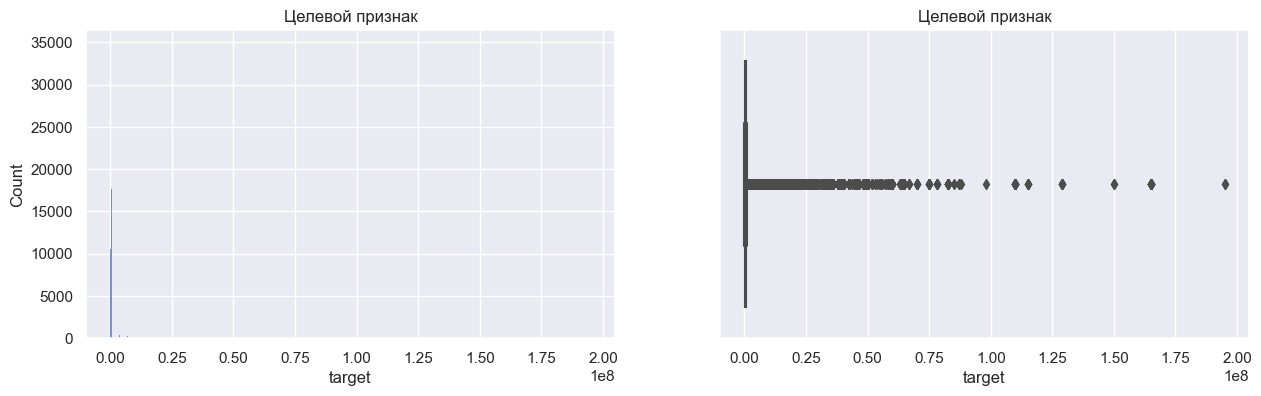

In [136]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='target', ax=axes[0])
histplot.set_title('Целевой признак')
boxplot = sns.boxplot(data=df, x='target', ax=axes[1])
boxplot.set_title('Целевой признак')

Видим, что присутствую выбросы, попробуем избавиться от них с помощью метода Тьюки

In [137]:
# метод Тьюки
def outliers_iqr(data, target):
    x = df['target']
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned
# применим функцию
outliers, cleaned = outliers_iqr(df, 'target')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 160496
Результирующее число записей: 1593438


Text(0.5, 1.0, 'Log target')

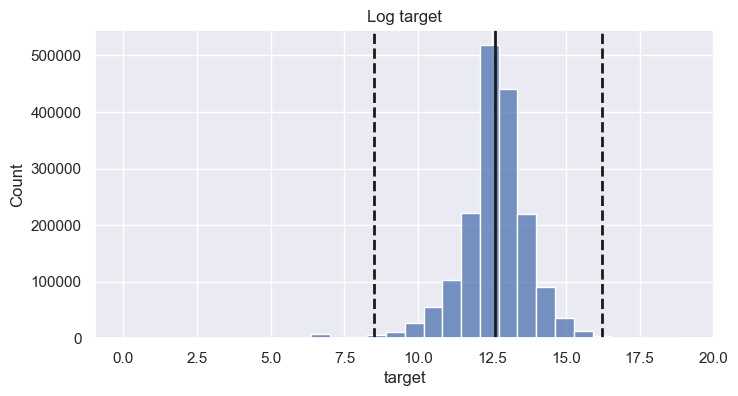

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(df['target'])
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean()+ 3.2 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean()- 3.6 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log target')

попробуем воспользоваться методом z-отклонений и дать 'послабление' влево. Это нужно, т.к. в данном датасете есть не только покупка недвижимости, но и аренда, а там цена ниже. Также сделаем небольшое "послабление" вправо для того, чтобы не выкидывать дорогой сегмент

In [139]:
# метод z - отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(df['target'])
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3.6 * sigma
    upper_bound = mu + 3.2 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score(df, 'target', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 13333
Результирующее число записей: 1740601


In [140]:
# сохраним
cleaned.to_csv("data/df.csv", index=False)

## Работа с очищенными данными

In [4]:
# загрузим датасет
df = pd.read_csv('data/df.csv')
df

status   propertyType  baths    sqft state     target street_types  \
0          active  single family    3.5  2900.0    NC   418000.0           ln   
1        for sale  single family      3  1947.0    WA   310000.0          ave   
2        for sale  single family      2  3000.0    CA  2895000.0           rd   
3        for sale  single family      2  3000.0    CA  2895000.0           rd   
4        for sale  single family  other  6457.0    TX  2395000.0          ave   
...           ...            ...    ...     ...   ...        ...          ...   
1740596  for sale  single family      2  1462.0    TX   204900.0           dr   
1740597  for sale  single family      2  1462.0    TX   204900.0           dr   
1740598  for sale  single family      2  1462.0    TX   204900.0           dr   
1740599  for sale  single family      2  1462.0    TX   204900.0           dr   
1740600  for sale  single family      2  1462.0    TX   204900.0           dr   

            heating  cooling    parking  lotsize  price_sqft  population  \
0             other  no data    no data   8276.0       144.0     15701.0   
1           no data  no data    no data   5828.0       159.0    103761.0   
2        forced air  central  attached    8626.0       965.0  11922389.0   
3        forced air  central  attached    8626.0       965.0       430.0   
4        forced air  central  detached    8220.0       371.0   5830932.0   
...             ...      ...        ...      ...         ...         ...   
1740596    electric  central    no data   6969.0       140.0      7351.0   
1740597    electric  central    no data   6969.0       140.0      1981.0   
1740598    electric  central    no data   6969.0       140.0      1788.0   
1740599    electric  central    no data   6969.0       140.0      1375.0   
1740600    electric  central    no data   6969.0       140.0        70.0   

         rating_hand  distance_mean  schools_count  
0                5.0              5            8.0  
1                4.0              1            3.0  
2                7.0              1            3.0  
3                7.0              1            3.0  
4                9.0              0            4.0  
...              ...            ...            ...  
1740596          4.0              1            3.0  
1740597          4.0              1            3.0  
1740598          4.0              1            3.0  
1740599          4.0              1            3.0  
1740600          4.0              1            3.0  

[1740601 rows x 16 columns]

In [142]:
df.describe()

sqft        target       lotsize    price_sqft    population  \
count  1.740601e+06  1.740601e+06  1.740601e+06  1.740601e+06  1.740601e+06   
mean   6.482428e+03  5.180538e+05  7.980864e+04  5.071449e+02  4.882252e+05   
std    1.513315e+06  7.671407e+05  5.906501e+06  3.255828e+04  1.788478e+06   
min    0.000000e+00  4.950000e+03  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.306000e+03  1.800000e+05  5.998000e+03  1.250000e+02  4.960000e+02   
50%    1.800000e+03  3.100000e+05  8.276000e+03  1.770000e+02  1.981000e+03   
75%    2.460000e+03  5.500000e+05  1.089000e+04  2.530000e+02  1.694500e+04   
max    7.959794e+08  1.126479e+07  2.147484e+09  5.950000e+06  1.890861e+07   

        rating_hand  distance_mean  schools_count  
count  1.740601e+06   1.740601e+06   1.740601e+06  
mean   4.969892e+00   2.075584e+00   4.650809e+00  
std    1.981142e+00   3.807326e+00   6.680119e+00  
min    1.000000e+00   0.000000e+00   1.000000e+00  
25%    3.000000e+00   1.000000e+00   3.000000e+00  
50%    5.000000e+00   1.000000e+00   3.000000e+00  
75%    6.000000e+00   2.000000e+00   5.000000e+00  
max    1.000000e+01   1.590000e+03   6.500000e+01

In [143]:
# посмотрим на информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1740601 entries, 0 to 1740600
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   status         object 
 1   propertyType   object 
 2   baths          object 
 3   sqft           float64
 4   state          object 
 5   target         float64
 6   street_types   object 
 7   heating        object 
 8   cooling        object 
 9   parking        object 
 10  lotsize        float64
 11  price_sqft     float64
 12  population     float64
 13  rating_hand    float64
 14  distance_mean  int64  
 15  schools_count  float64
dtypes: float64(7), int64(1), object(8)
memory usage: 212.5+ MB


In [144]:
# посмотрим на количество пропущенных значений
df.isnull().sum()

status           0
propertyType     0
baths            0
sqft             0
state            0
target           0
street_types     0
heating          0
cooling          0
parking          0
lotsize          0
price_sqft       0
population       0
rating_hand      0
distance_mean    0
schools_count    0
dtype: int64

In [145]:
# посмотрим на отчет по датасету
profile = ProfileReport(df, title="Profiling Report")
profile.to_notebook_iframe()
profile.to_file("data/profilereport.html") # сохраниние отчета в файл

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# удалим дубликаты
df = df.drop_duplicates()

### Отбор признаков

In [161]:
fig = px.histogram(
    data_frame=df.groupby(['status'], as_index=False)['target'].mean(),
    x='status',
    y= ['target'],
    color='status',
    height=500,
    width=1000,
    title='Зависимость статуса обьекта от его цены',
    text_auto=True
)

fig.show()

Мы видим, что статус объекта влияет на его цену. Выше всего цены у объектов со статусом 'new construction'

In [185]:
fig = px.bar(
    data_frame= df.groupby(['propertyType'], as_index=False)['distance_mean'].mean(),
    x='propertyType',
    y='distance_mean',
    color='propertyType',
    text='distance_mean',
    orientation='v',
    title='Зависимость среднего расстояния до школы от типа жилья',
    height=500,
    width=1000
)

fig.show()

Мы видим, что есть зависимость расстояния до школы от типа жилья. Самое маленькое расстояние в многоквартирных домах, а самое большое в отдельностоящих

In [163]:
fig = px.histogram(
    data_frame=df.groupby(['state'], as_index=False)['target'].mean(),
    x='state',
    y= ['target'],
    color='state',
    height=500,
    width=1000,
    title='Зависимость штата, где находидится  обьект от его цены',
    text_auto=True
)

fig.show()

Штат очень сильно влияет на среднюю цену объекта. Массачусетс и Нью-Йорк являются шататами с самым дорогим жильём

In [164]:
fig = px.bar(
    data_frame= df.groupby(['propertyType'], as_index=False)['target'].median().sort_values(by=['target'], ascending=False),
    x='propertyType',
    y='target',
    color='propertyType',
    text='target',
    orientation='v',
    title='Зависимость медианной стоимости объекта от его типа',
    height=500,
    width=1000
)

fig.show()

Самая высокая стоимость у отдельностоящих домов (single detached)

In [6]:
# закодируем категориальные признаки
cols_to_code = ['status', 'propertyType', 'baths', 'state', 'street_types', 'heating', 'cooling', 'parking']
enc = ce.BinaryEncoder(cols=cols_to_code)
df_enc = enc.fit_transform(df)
df_enc

status_0  status_1  status_2  propertyType_0  propertyType_1  \
0               0         0         1               0               0   
1               0         1         0               0               0   
2               0         1         0               0               0   
3               0         1         0               0               0   
4               0         1         0               0               0   
...           ...       ...       ...             ...             ...   
1740596         0         1         0               0               0   
1740597         0         1         0               0               0   
1740598         0         1         0               0               0   
1740599         0         1         0               0               0   
1740600         0         1         0               0               0   

         propertyType_2  propertyType_3  baths_0  baths_1  baths_2  ...  \
0                     0               1        0        0        0  ...   
1                     0               1        0        0        1  ...   
2                     0               1        0        0        1  ...   
3                     0               1        0        0        1  ...   
4                     0               1        0        1        0  ...   
...                 ...             ...      ...      ...      ...  ...   
1740596               0               1        0        0        1  ...   
1740597               0               1        0        0        1  ...   
1740598               0               1        0        0        1  ...   
1740599               0               1        0        0        1  ...   
1740600               0               1        0        0        1  ...   

         parking_0  parking_1  parking_2  parking_3  lotsize  price_sqft  \
0                0          0          0          1   8276.0       144.0   
1                0          0          0          1   5828.0       159.0   
2                0          0          1          0   8626.0       965.0   
3                0          0          1          0   8626.0       965.0   
4                0          0          1          1   8220.0       371.0   
...            ...        ...        ...        ...      ...         ...   
1740596          0          0          0          1   6969.0       140.0   
1740597          0          0          0          1   6969.0       140.0   
1740598          0          0          0          1   6969.0       140.0   
1740599          0          0          0          1   6969.0       140.0   
1740600          0          0          0          1   6969.0       140.0   

         population  rating_hand  distance_mean  schools_count  
0           15701.0          5.0              5            8.0  
1          103761.0          4.0              1            3.0  
2        11922389.0          7.0              1            3.0  
3             430.0          7.0              1            3.0  
4         5830932.0          9.0              0            4.0  
...             ...          ...            ...            ...  
1740596      7351.0          4.0              1            3.0  
1740597      1981.0          4.0              1            3.0  
1740598      1788.0          4.0              1            3.0  
1740599      1375.0          4.0              1            3.0  
1740600        70.0          4.0              1            3.0  

[1702877 rows x 41 columns]

In [7]:
# построим матрицу коореляции
corr = df_enc.corr().round(3)
corr.style.background_gradient(cmap='coolwarm')

У нас есть несколько некритично скоорелированных признаков, например, статус жилья и количество машиномест, отопление и статус жилья. Пока не буду их удалять, но учту это при отборе признаков в самом конце

In [8]:
# Разделение данных на обучающую и тестовую выборки
X = enc.fit_transform(df.drop(['target'], axis=1))
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()
# кодируем исходный датасет
X_train_scal = r_scaler.fit_transform(X_train)
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)
X_test_scal = pd.DataFrame(r_scaler.transform(X_test), columns=X_test.columns)

In [151]:
X_train_scal

status_0  status_1  status_2  propertyType_0  propertyType_1  \
0             0.0       0.0       0.0             0.0             0.0   
1             0.0       0.0       0.0             0.0             1.0   
2             0.0       0.0       0.0             0.0             0.0   
3             0.0       0.0       0.0             0.0             0.0   
4             0.0       0.0       0.0             0.0             0.0   
...           ...       ...       ...             ...             ...   
1362296       0.0       0.0       0.0             0.0             0.0   
1362297       0.0       0.0       0.0             0.0             0.0   
1362298       0.0       0.0       0.0             0.0             0.0   
1362299       0.0       0.0       0.0             0.0             0.0   
1362300       0.0       0.0       0.0             0.0             0.0   

         propertyType_2  propertyType_3  baths_0  baths_1  baths_2  ...  \
0                   0.0             0.0      0.0      1.0     -1.0  ...   
1                   1.0             0.0      0.0      0.0      0.0  ...   
2                   0.0             0.0      0.0      0.0      0.0  ...   
3                   1.0            -1.0      0.0      1.0     -1.0  ...   
4                   1.0             0.0      0.0      1.0     -1.0  ...   
...                 ...             ...      ...      ...      ...  ...   
1362296             0.0             0.0      0.0      0.0      0.0  ...   
1362297             0.0             0.0      0.0      0.0      0.0  ...   
1362298             0.0             0.0      0.0      1.0     -1.0  ...   
1362299             1.0             0.0      0.0      0.0      0.0  ...   
1362300             0.0             0.0      0.0      0.0      0.0  ...   

         parking_0  parking_1  parking_2  parking_3    lotsize  price_sqft  \
0              0.0        0.0        1.0       -1.0  11.753802    2.992308   
1              0.0        0.0        0.0        0.0   0.000000    3.123077   
2              0.0        0.0        0.0        0.0   0.000000    0.207692   
3              0.0        0.0        0.0        0.0  16.384056    0.000000   
4              1.0        0.0        0.0       -1.0  -1.551513    0.923077   
...            ...        ...        ...        ...        ...         ...   
1362296        0.0        1.0        0.0        0.0   0.000000   -0.392308   
1362297        0.0        1.0        0.0        0.0  -0.414146    1.069231   
1362298        0.0        0.0        0.0        0.0   0.801472    1.176923   
1362299        0.0        0.0        1.0       -1.0  -1.339534   -0.415385   
1362300        0.0        0.0        0.0        0.0  -0.356092    0.623077   

         population  rating_hand  distance_mean  schools_count  
0        136.547267     1.666667            0.0            0.0  
1         -0.038179     0.333333           10.0           -0.5  
2          0.227430    -0.666667            0.0            0.0  
3         32.364703    -0.666667            1.0            0.0  
4         -0.102073    -1.000000           -1.0           -0.5  
...             ...          ...            ...            ...  
1362296   -0.011733    -1.000000            1.0            0.0  
1362297   -0.047237     0.000000           -1.0            0.0  
1362298    0.132227     0.000000            0.0            0.0  
1362299  345.404098    -1.333333           -1.0            0.0  
1362300   -0.101648     0.333333           -1.0           -0.5  

[1362301 rows x 40 columns]

In [152]:
# С помощью SelectKBest отберём 25 наиболее важных, используя параметр score_func = f_regression.

select = feature_selection.SelectKBest(score_func = f_regression, k=25)
z = select.fit_transform(X_train,y_train)

In [153]:
filter_kb = select.get_support()

features = X_train.columns
print(features[filter_kb])

Index(['status_0', 'propertyType_1', 'baths_0', 'baths_1', 'baths_2',
       'baths_3', 'state_1', 'state_2', 'state_3', 'state_4', 'state_5',
       'street_types_2', 'street_types_3', 'heating_1', 'heating_3',
       'cooling_2', 'cooling_3', 'parking_0', 'parking_2', 'parking_3',
       'price_sqft', 'population', 'rating_hand', 'distance_mean',
       'schools_count'],
      dtype='object')


In [154]:
X_train = X_train[features[filter_kb]]
X_test = X_test[features[filter_kb]]

## Подбор модели

Поскольку нам нужно обучить модель определению непрерывных значений, мы будем использовать эти регрессионные модели:

SVM-метод опорных векторов

Случайный лес

Линейная регрессия

Полиноминальная регрессия


в качестве метрик будем использовать:
- Среднюю абсолютную ошибку (MAE)
- Среднеквадратичную ошибку(MSE)
- Коэффициен детерминации(R-квадрат)

### Сравнение моделей

In [ ]:
# Линейная регрессия

model = LinearRegression()
params = {'fit_intercept': [True, False]}
grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

LinearRegression_best_params = grid_search.best_params_
print("LinearRegression_best_params: ", LinearRegression_best_params)
LinearRegression_mse = mean_squared_error(y_test, y_pred)
print("LinearRegression_mse: ", LinearRegression_mse)
LinearRegression_MAE = metrics.mean_absolute_error(y_test, y_pred)
print("LinearRegression_MAE: ", LinearRegression_MAE)
LinearRegression_R2 = metrics.r2_score(y_test, y_pred)
print("LinearRegression_R2: ", LinearRegression_R2)



LinearRegression_best_params:  {'fit_intercept': True}
LinearRegression_mse:  514066545413.4234
LinearRegression_MAE:  366124.5239819267
LinearRegression_R2:  0.14839061115389518


In [ ]:
# Полиноминальная регрессия
model = preprocessing.PolynomialFeatures(degree=2, include_bias=True)


model.fit(X_train)
X_train_poly = model.transform(X_train)
X_test_poly = model.transform(X_test)

model_lin_poly = linear_model.LinearRegression()
model_lin_poly.fit(X_train_poly, y_train)
y_test_pred = model_lin_poly.predict(X_test_poly)

PolynomialFeatures_mse = metrics.mean_squared_error(y_test, y_test_pred)
print("PolynomialFeatures_mse: ", PolynomialFeatures_mse)
PolynomialFeatures_MAE = metrics.mean_absolute_error(y_test,y_test_pred)
print("PolynomialFeatures_MAE: ", PolynomialFeatures_MAE)
PolynomialFeatures_R2 = metrics.r2_score(y_test, y_test_pred)
print("PolynomialFeatures_R2: ", PolynomialFeatures_R2)


PolynomialFeatures_mse:  439513560097.7843
PolynomialFeatures_MAE:  301041.8565914522
PolynomialFeatures_R2:  0.27189606551145107


In [ ]:
# Деревья решений
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)


DecisionTreeRegressor_mse = metrics.mean_squared_error(y_test, y_test_pred)
print("DecisionTreeRegressor_mse: ", DecisionTreeRegressor_mse)
DecisionTreeRegressors_MAE = metrics.mean_absolute_error(y_test, y_test_pred)
print("DecisionTreeRegressor_MAE: ", DecisionTreeRegressors_MAE)
DecisionTreeRegressor_R2 = metrics.r2_score(y_test, y_test_pred)
print("DecisionTreeRegressor_R2: ", DecisionTreeRegressor_R2)

DecisionTreeRegressor_mse:  109189344551.60251
DecisionTreeRegressor_MAE:  57084.4699970984
DecisionTreeRegressor_R2:  0.8191154981553699


In [ ]:
# Создание объекта RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Вычисление метрик
RandomForestRegressor_mse = mean_squared_error(y_test, y_pred)
print("RandomForestRegressor_mse: ", RandomForestRegressor_mse)
RandomForestRegressor_MAE = metrics.mean_absolute_error(y_test, y_pred)
print("RandomForestRegressor_MAE: ", RandomForestRegressor_MAE)
RandomForestRegressor_R2 = metrics.r2_score(y_test, y_pred)
print("RandomForestRegressor_R2: ", RandomForestRegressor_R2)

RandomForestRegressor_mse:  81240433469.12564
RandomForestRegressor_MAE:  61046.50340430154
RandomForestRegressor_R2:  0.8654160312249175


In [ ]:
# градиентный бустинг

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor()

# Обучаем модель
gb.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки

y_pred = gb.predict(X_test)

# Вычисление метрик
GradientBoostingRegressor_mse = mean_squared_error(y_test, y_pred)
print("GradientBoostingRegressor_mse: ", GradientBoostingRegressor_mse)
GradientBoostingRegressor_MAE = metrics.mean_absolute_error(y_test, y_pred)
print("GradientBoostingRegressor_MAE: ",GradientBoostingRegressor_MAE)
GradientBoostingRegressor_R2 = metrics.r2_score(y_test, y_pred)
print("AdaBoostRegressor_R2: ", GradientBoostingRegressor_R2)


GradientBoostingRegressor_mse:  267595006669.43576
GradientBoostingRegressor_MAE:  229682.00804865282
AdaBoostRegressor_R2:  0.556698598418311


In [ ]:
# бустинг AdaBoost
dt = DecisionTreeRegressor(
    max_depth=3, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Создаем объект класса AdaBoost
ada = AdaBoostRegressor(
    estimator=dt, #базовая модель
    random_state=42, #датчик генератора случайных чисел
    n_estimators=50, #количество моделей в ансамбле
    learning_rate=0.01
)
# Обучаем модель
ada.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
y_pred  = ada.predict(X_test)

# Вычисление метрик
AdaBoostRegressor_mse = mean_squared_error(y_test, y_pred)
print("AdaBoostRegressor_mse: ", AdaBoostRegressor_mse)
AdaBoostRegressor_MAE = metrics.mean_absolute_error(y_test, y_pred)
print("AdaBoostRegressor_MAE: ", AdaBoostRegressor_MAE)
AdaBoostRegressor_R2 = metrics.r2_score(y_test, y_pred)
print("AdaBoostRegressor_R2: ", AdaBoostRegressor_R2)


AdaBoostRegressor_mse:  369994042336.5187
AdaBoostRegressor_MAE:  300641.20959986973
AdaBoostRegressor_R2:  0.3870630114288024


In [ ]:
# Создание объекта XGBRegressor
model = XGBRegressor()
# Определение параметров для GridSearchCV
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01],
    'max_depth': [3, 5]
}
# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error')
# Обучение модели на обучающих данных
grid_search.fit(X_train, y_train)
# Получение лучшей модели
best_model = grid_search.best_estimator_
# Предсказание на тестовых данных
y_pred = best_model.predict(X_test)
# Получение лучших параметров XGBRegressor
XGBRegressor_best_params = grid_search.best_params_
print("XGBRegressor_best_params: ", XGBRegressor_best_params)
# Вычисление метрик
XGBRegressor_mse = mean_squared_error(y_test, y_pred)
print("XGBRegressor_mse: ", XGBRegressor_mse)

XGBRegressor_MAE = metrics.mean_absolute_error(y_test, y_pred)
print("XGBRegressor_MAE: ", XGBRegressor_MAE)
XGBRegressor_R2 = metrics.r2_score(y_test, y_pred)
print("XGBRegressor_R2: ", XGBRegressor_R2)

XGBRegressor_best_params:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
XGBRegressor_mse:  277831998215.15674
XGBRegressor_MAE:  237217.0673199168
XGBRegressor_R2:  0.5397398638115627


In [ ]:
# Создание объекта CatBoostRegressor
model = CatBoostRegressor(verbose=False ,subsample=1.0, colsample_bylevel=1.0, reg_lambda=3.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Вычисление метрик
CatBoostRegressor_mse = mean_squared_error(y_test, y_pred)
print("CatBoostRegressor_mse: ", CatBoostRegressor_mse)
CatBoostRegressor_MAE = metrics.mean_absolute_error(y_test, y_pred)
print("CatBoostRegressor_MAE: ", CatBoostRegressor_MAE)
CatBoostRegressor_R2 = metrics.r2_score(y_test, y_pred)
print("CatBoostRegressor_R2: ", CatBoostRegressor_R2)

CatBoostRegressor_mse:  192302650192.2087
CatBoostRegressor_MAE:  186502.7620563133
CatBoostRegressor_R2:  0.6814289047501265


In [ ]:
# Вывод результатов моделей регрессии

data = [
    ['LinearRegression', f'{LinearRegression_mse}', f'{LinearRegression_MAE}', f'{LinearRegression_R2}'],
    ['PolynomialFeatures', f'{PolynomialFeatures_mse}', f'{PolynomialFeatures_MAE}', f'{PolynomialFeatures_R2}'],
    ['DecisionTreeRegressor', f'{DecisionTreeRegressor_mse}', f'{DecisionTreeRegressors_MAE}', f'{DecisionTreeRegressor_R2}'],
    ['RandomForestRegressor', f'{RandomForestRegressor_mse}', f'{RandomForestRegressor_MAE}', f'{RandomForestRegressor_R2}'],
    ['GradientBoostingRegressor', f'{GradientBoostingRegressor_mse}', f'{GradientBoostingRegressor_MAE}', f'{GradientBoostingRegressor_R2}'],
    ['AdaBoostRegressor', f'{AdaBoostRegressor_mse}', f'{AdaBoostRegressor_MAE}', f'{AdaBoostRegressor_R2}'],
    ['XGBRegressor', f'{XGBRegressor_mse}', f'{XGBRegressor_MAE}', f'{XGBRegressor_R2}'],
    ['CatBoostRegressor', f'{CatBoostRegressor_mse}', f'{CatBoostRegressor_MAE}', f'{CatBoostRegressor_R2}']
]


# Создание DataFrame из данных
df = pd.DataFrame(data, columns=['Модель', 'MSE', 'MAE', 'R2'], index=range(1, 1 + len(data)))
pd.set_option('display.max_colwidth', None)

df.head(len(data))

Модель                 MSE                 MAE  \
1           LinearRegression   514066545413.4234   366124.5239819267   
2         PolynomialFeatures   439513560097.7843   301041.8565914522   
3      DecisionTreeRegressor  109189344551.60251    57084.4699970984   
4      RandomForestRegressor   81240433469.12564   61046.50340430154   
5  GradientBoostingRegressor  267595006669.43576  229682.00804865282   
6          AdaBoostRegressor   369994042336.5187  300641.20959986973   
7               XGBRegressor  277831998215.15674   237217.0673199168   
8          CatBoostRegressor   192302650192.2087   186502.7620563133   

                    R2  
1  0.14839061115389518  
2  0.27189606551145107  
3   0.8191154981553699  
4   0.8654160312249175  
5    0.556698598418311  
6   0.3870630114288024  
7   0.5397398638115627  
8   0.6814289047501265

В фаворитах оказался случайный лес. Попробуем обучить модель на всех признаках

In [ ]:
# Создание объекта RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train_scal, y_train)
y_pred = model.predict(X_test_scal)
y_pred_train = model.predict(X_train_scal)

# Вычисление метрик
print('test')
RandomForestRegressor_mse = mean_squared_error(y_test, y_pred)
print("RandomForestRegressor_mse: ", RandomForestRegressor_mse)
RandomForestRegressor_MAE = metrics.mean_absolute_error(y_test, y_pred)
print("RandomForestRegressor_MAE: ", RandomForestRegressor_MAE)
RandomForestRegressor_R2 = metrics.r2_score(y_test, y_pred)
print("RandomForestRegressor_R2: ", RandomForestRegressor_R2)
print('train')
RandomForestRegressor_mse = mean_squared_error(y_train, y_pred_train)
print("RandomForestRegressor_mse: ", RandomForestRegressor_mse)
RandomForestRegressor_MAE = metrics.mean_absolute_error(y_train, y_pred_train)
print("RandomForestRegressor_MAE: ", RandomForestRegressor_MAE)
RandomForestRegressor_R2 = metrics.r2_score(y_train,y_pred_train)
print("RandomForestRegressor_R2: ", RandomForestRegressor_R2)

test
RandomForestRegressor_mse:  32701131606.118164
RandomForestRegressor_MAE:  19946.800537402516
RandomForestRegressor_R2:  0.9442970224723388
train
RandomForestRegressor_mse:  18854852580.079117
RandomForestRegressor_MAE:  12681.560238597769
RandomForestRegressor_R2:  0.9680704715809041


Как мы видим, модель, обученная на всех признаках, даёт значение метрик лучше, но такая модель нестабильна

In [ ]:
# Создание объекта RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
# Вычисление метрик
print('test')
RandomForestRegressor_mse = mean_squared_error(y_test, y_pred)
print("RandomForestRegressor_mse: ", RandomForestRegressor_mse)
RandomForestRegressor_MAE = metrics.mean_absolute_error(y_test, y_pred)
print("RandomForestRegressor_MAE: ", RandomForestRegressor_MAE)
RandomForestRegressor_R2 = metrics.r2_score(y_test, y_pred)
print("RandomForestRegressor_R2: ", RandomForestRegressor_R2)

print('train')
RandomForestRegressor_mse = mean_squared_error(y_train, y_pred_train)
print("RandomForestRegressor_mse: ", RandomForestRegressor_mse)
RandomForestRegressor_MAE = metrics.mean_absolute_error(y_train, y_pred_train)
print("RandomForestRegressor_MAE: ", RandomForestRegressor_MAE)
RandomForestRegressor_R2 = metrics.r2_score(y_train, y_pred_train)
print("RandomForestRegressor_R2: ", RandomForestRegressor_R2)

test
RandomForestRegressor_mse:  85404865930.02274
RandomForestRegressor_MAE:  64630.96860011023
RandomForestRegressor_R2:  0.8555602663881963
train
RandomForestRegressor_mse:  41475915521.88015
RandomForestRegressor_MAE:  37100.73383917233
RandomForestRegressor_R2:  0.929637335019823


Модель с ранее отобранными признаки демонстрирует результат хуже, чем если бы она обучалась на всех признаках. И рельтат не является стабильным. Попробуем заново отобрать признаки, для этого воспользуемся  CatBoost

In [11]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal, y_train)

y_train_pred  = catmodel.predict(X_train_scal)
y_test_pred = catmodel.predict(X_test_scal)

print('test')
CatBoostRegressor_mse = mean_squared_error(y_test,y_test_pred)
print("CatBoostRegressor_mse: ", CatBoostRegressor_mse)
CatBoostRegressor_MAE = metrics.mean_absolute_error(y_test, y_test_pred)
print("CatBoostRegressor_MAE: ", CatBoostRegressor_MAE)
CatBoostRegressor_R2 = metrics.r2_score(y_test, y_test_pred)
print("CatBoostRegressor_R2: ", CatBoostRegressor_R2)

print('train')
CatBoostRegressor_mse = mean_squared_error(y_train, y_train_pred)
print("CatBoostRegressor: ", CatBoostRegressor_mse)
CatBoostRegressor = metrics.mean_absolute_error(y_train, y_train_pred)
print("CatBoostRegressor: ", CatBoostRegressor_MAE)
CatBoostRegressor_R2 = metrics.r2_score(y_train, y_train_pred)
print("CatBoostRegressor: ", CatBoostRegressor_R2)

test
CatBoostRegressor_mse:  70776021540.04617
CatBoostRegressor_MAE:  64360.2601559668
CatBoostRegressor_R2:  0.8801265328644443
train
CatBoostRegressor:  66788510283.53631
CatBoostRegressor:  64360.2601559668
CatBoostRegressor:  0.8867366511919892


In [12]:
# признаки и их веса в моделе
best_feature_cat = pd.DataFrame({'feature_importance': catmodel.get_feature_importance(),
              'feature_names':X_train_scal.columns}).sort_values(by=['feature_importance'],
                                                           ascending=False)
# топ-7 признаков по весам
new_best = best_feature_cat['feature_names'].iloc[:7]
best_feature_cat[:7]

feature_importance  feature_names
35           43.271867     price_sqft
11           36.680106           sqft
34            4.081156        lotsize
36            2.683157     population
37            1.949960    rating_hand
38            1.847292  distance_mean
39            1.317907  schools_count

In [172]:
# построим модель по новым признакам
random_forest = ensemble.RandomForestRegressor(n_estimators=200,
                                               max_depth=13,
                                               criterion='squared_error',
                                               random_state=42)

random_forest.fit(X_train_scal[new_best], y_train)

y_train_pred = random_forest.predict(X_train_scal[new_best])
y_test_pred = random_forest.predict(X_test_scal[new_best])

# Вычисление
print('test')
RandomForestRegressor_mse = mean_squared_error(y_test, y_test_pred)
print("RandomForestRegressor_mse: ", RandomForestRegressor_mse)
RandomForestRegressor_MAE = metrics.mean_absolute_error(y_test, y_test_pred)
print("RandomForestRegressor_MAE: ", RandomForestRegressor_MAE)
RandomForestRegressor_R2 = metrics.r2_score(y_test, y_test_pred)
print("RandomForestRegressor_R2: ", RandomForestRegressor_R2)

print('train')
RandomForestRegressor_mse = mean_squared_error(y_train, y_train_pred)
print("RandomForestRegressor_mse: ", RandomForestRegressor_mse)
RandomForestRegressor_MAE = metrics.mean_absolute_error(y_train, y_train_pred)
print("RandomForestRegressor_MAE: ", RandomForestRegressor_MAE)
RandomForestRegressor_R2 = metrics.r2_score(y_train, y_train_pred)
print("RandomForestRegressor_R2: ", RandomForestRegressor_R2)

test
RandomForestRegressor_mse:  77447290845.44197
RandomForestRegressor_MAE:  58932.49814226988
RandomForestRegressor_R2:  0.8679649174815323
train
RandomForestRegressor_mse:  75733154978.11034
RandomForestRegressor_MAE:  58247.97166881311
RandomForestRegressor_R2:  0.8717774726311043


In [175]:
# визуализируем важные признаки в дереве решений
top = pd.DataFrame([random_forest.feature_importances_], columns=X_train_scal[new_best].columns)
fig = px.bar(
    x=list(top.loc[0].sort_values(ascending=False).index),
    y=round(top.loc[0].sort_values(ascending=False), 2),
    text_auto=True,
    title='Top-7 features for RandomForest',
    height=500,
    width=1000,
    labels={'x':'feature_importances', 'y':'weight'}

)
fig.show()

## Подготовка к продакшену

In [13]:
# построим модель по новым признакам
random_forest_model = ensemble.RandomForestRegressor(n_estimators=200,
                                               max_depth=13,
                                               criterion='squared_error',
                                               random_state=42)

random_forest_model.fit(X_train_scal[new_best], y_train)

y_train_pred = random_forest_model.predict(X_train_scal[new_best])
y_test_pred = random_forest_model.predict(X_test_scal[new_best])

# Вычисление
print('test')
random_forest_model_mse = mean_squared_error(y_test, y_test_pred)
print("Rrandom_forest_model_mse: ", random_forest_model_mse)
random_forest_model_MAE = metrics.mean_absolute_error(y_test, y_test_pred)
print("random_forest_model_MAE: ", random_forest_model_MAE)
random_forest_model_R2 = metrics.r2_score(y_test, y_test_pred)
print("random_forest_model_R2: ", random_forest_model_R2)

print('train')
random_forest_model_mse = mean_squared_error(y_train, y_train_pred)
print("random_forest_model_mse: ", random_forest_model_mse)
random_forest_model_MAE = metrics.mean_absolute_error(y_train, y_train_pred)
print("random_forest_model_MAE: ", random_forest_model_MAE)
random_forest_model_R2 = metrics.r2_score(y_train, y_train_pred)
print("random_forest_model_R2: ", random_forest_model_R2)

test
Rrandom_forest_model_mse:  79025313940.61212
random_forest_model_MAE:  59347.90960619681
random_forest_model_R2:  0.8661546924027519
train
random_forest_model_mse:  75318232266.8241
random_forest_model_MAE:  58119.4579032825
random_forest_model_R2:  0.8722715153156672


In [187]:
with open('models/best_model.pkl', 'wb') as output:
    pickle.dump(random_forest_model, output)